# Import

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import seaborn as sns
import time
from torchviz import make_dot, make_dot_from_trace
from skimage import io, transform
from torch import tensor
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn import preprocessing
from typing import List
from IPython.display import clear_output
import sys
sys.path.insert(0, '/home/caitao/Project/dl-localization')
from input_output import Default
from utility import Utility
from torch._six import container_abcs, string_classes, int_classes
import re
np_str_obj_array_pattern = re.compile(r'[SaUO]')
default_collate_err_msg_format = (
    "default_collate: batch must contain tensors, numpy arrays, numbers, "
    "dicts or lists; found {}")

# 1 Common modules

In [2]:
class MinMaxNormalize:
    '''Min max normalization, the new bound is (lower, upper)
    '''
    def __init__(self, lower=0, upper=1):
        assert isinstance(lower, (int, float))
        assert isinstance(upper, (int, float))
        self.lower = lower
        self.upper = upper

    def __call__(self, matrix):
        minn = matrix.min()
        maxx = matrix.max()
        matrix = (matrix - minn) / (maxx - minn)
        if self.lower != 0 or self.upper != 1:
            matrix = self.lower + matrix * (self.upper - self.lower)
        return matrix.astype(np.float32)

class UniformNormalize:
    '''Set a uniform threshold accross all samples
    '''
    def __init__(self, noise_floor):
        self.noise_floor = noise_floor

    def __call__(self, matrix):
        matrix -= self.noise_floor
        matrix /= (-self.noise_floor/2)
        return matrix.astype(np.float32)

class Metrics:
    '''Evaluation metrics
    '''
    @staticmethod
    def localization_error_image_continuous(pred_batch, pred_ntx, truth_batch, index, grid_len, debug=False):
        '''Continuous -- for single TX
           euclidian error when modeling the output representation is a matrix (image)
           both pred and truth are batches, typically a batch of 32
           now both prediction and truth are continuous numbers
        Args:
            pred_batch:  numpy.ndarray -- size=(N, 1, 100, 100)
            truth_batch: numpy.ndarray -- size=(N, num_tx, 2)
        Return:
            pred_locs -- list<np.ndarray>
            errors    -- list<list>
            misses    -- list
            false     -- list
        '''
        def float_target(pred_matrix, pred_peaks):
            new_pred_peaks = []
            for pred_x, pred_y in pred_peaks:
                sum_weight = 0
                neighbor = []
                for d in [(0, 0), (-1, 0), (0, 1), (1, 0), (0, -1)]:
                    nxt = (pred_x + d[0], pred_y + d[1])
                    if 0 <= nxt[0] < grid_len and 0 <= nxt[1] < grid_len:
                        neighbor.append(((nxt[0] + 0.5, nxt[1] + 0.5), pred[nxt[0]][nxt[1]]))
                        sum_weight += pred_matrix[nxt[0]][nxt[1]]
                pred_x, pred_y = 0, 0
                for n in neighbor:
                    loc = n[0]
                    w   = n[1]
                    pred_x += loc[0] / sum_weight * w
                    pred_y += loc[1] / sum_weight * w
                new_pred_peaks.append((pred_x, pred_y))
            return new_pred_peaks

        pred_locs = []
        errors = []
        misses = []
        falses = []
        for i, pred, pred_n, truth, indx in zip(range(len(pred_batch)), pred_batch, pred_ntx, truth_batch, index):
            # 1: get the multiple predicted locations
            pred = pred[0]           # there is only one channel
            pred_peaks, _ = Utility.detect_peak(pred, np.round(pred_n, 0), 0.1)         # get the predictions  TIME: 23 milliseconds
            pred_peaks = float_target(pred, pred_peaks)
            # 2: do a matching and get the error
            radius_threshold = Default.grid_length * Default.error_threshold
            error, miss, false = Utility.compute_error(pred_peaks, truth, radius_threshold, False)
            errors.append(error)
            misses.append(miss)
            falses.append(false)
            if debug:
                print(i, indx, 'pred', [(round(loc[0], 2), round(loc[1], 2)) for loc in pred_peaks], '; truth', \
                      [(round(loc[0], 2), round(loc[1], 2)) for loc in truth], ' ; error', error, ' ; miss', miss, ' ; false', false)
        return errors, misses, falses

    @staticmethod
    def loss(pred, y):
        n = len(pred) * len(pred[0])
        summ = np.sum((pred - y)**2)
        return summ/n

In [3]:
def my_padding(batch, max_len):
    """add zeros to elements that are not maximum length"""
    for i in range(len(batch)):
        diff = max_len - len(batch[i])
        if diff > 0:                      # padding
            zeros = torch.zeros(diff, 2)
            padded = torch.cat((batch[i], zeros), 0)
            batch[i] = padded

def my_collate(batch):
    """Puts each data field into a tensor with outer dimension batch size"""
    elem = batch[0]
    elem_type = type(elem)
    if isinstance(elem, torch.Tensor):
        max_len = len(max(batch, key=len))
        min_len = len(min(batch, key=len))
        if max_len != min_len:
            my_padding(batch, max_len)
        out = None
        if torch.utils.data.get_worker_info() is not None:
            # If we're in a background process, concatenate directly into a
            # shared memory tensor to avoid an extra copy
            numel = sum([x.numel() for x in batch])
            storage = elem.storage()._new_shared(numel)
            out = elem.new(storage)
        return torch.stack(batch, 0, out=out)
    elif elem_type.__module__ == 'numpy' and elem_type.__name__ != 'str_' \
            and elem_type.__name__ != 'string_':
        if elem_type.__name__ == 'ndarray' or elem_type.__name__ == 'memmap':
            # array of string classes and object
            if np_str_obj_array_pattern.search(elem.dtype.str) is not None:
                raise TypeError(default_collate_err_msg_format.format(elem.dtype))

            return my_collate([torch.as_tensor(b) for b in batch])
        elif elem.shape == ():  # scalars
            return torch.as_tensor(batch)
    elif isinstance(elem, float):
        return torch.tensor(batch, dtype=torch.float64)
    elif isinstance(elem, int_classes):
        return torch.tensor(batch)
    elif isinstance(elem, string_classes):
        return batch
    elif isinstance(elem, container_abcs.Mapping):
        return {key: my_collate([d[key] for d in batch]) for key in elem}
    elif isinstance(elem, tuple) and hasattr(elem, '_fields'):  # namedtuple
        return elem_type(*(my_collate(samples) for samples in zip(*batch)))
    elif isinstance(elem, container_abcs.Sequence):
        # check to make sure that the elements in batch have consistent size
        it = iter(batch)
        elem_size = len(next(it))
        if not all(len(elem) == elem_size for elem in it):
            raise RuntimeError('each element in list of batch should be of equal size')
        transposed = zip(*batch)
        return [my_collate(samples) for samples in transposed]

    raise TypeError(default_collate_err_msg_format.format(elem_type))

def my_uncollate(y_num, y_float):
    """this is for uncollating the target_float"""
    y_float_tmp = []
    for ntx, y_f in zip(y_num, y_float):
        y_float_tmp.append(y_f[:ntx])
    return np.array(y_float_tmp, dtype=object)

# 2 Dataset

In [6]:
class SensorInputDatasetTranslation(Dataset):
    '''Sensor reading input dataset -- for multi TX
       Output is image, model as a image segmentation problem
    '''
    def __init__(self, root_dir: str, transform=None):
        '''
        Args:
            root_dir:  directory with all the images
            labels:    labels of images
            transform: optional transform to be applied on a sample
        '''
        self.root_dir = root_dir
        self.transform = transform
        self.length = len(os.listdir(self.root_dir))
        self.sample_per_label = self.get_sample_per_label()

    def __len__(self):
        return self.length * self.sample_per_label

    def __getitem__(self, idx):
        folder = int(idx/self.sample_per_label)
        folder = format(folder, '06d')
        matrix_name = str(idx%self.sample_per_label) + '.npy'
        matrix_path = os.path.join(self.root_dir, folder, matrix_name)
        target_name = str(idx%self.sample_per_label) + '.target.npy'
        target_img, target_float = self.get_translation_target(folder, target_name)
        matrix = np.load(matrix_path)
        if self.transform:
            matrix = self.transform(matrix)
        target_num = len(target_float)
        sample = {'matrix':matrix, 'target':target_img, 'target_float':target_float, 'target_num':target_num, 'index':idx}
        return sample

    def get_sample_per_label(self):
        folder = glob.glob(os.path.join(self.root_dir, '*'))[0]
        samples = glob.glob(os.path.join(folder, '*.npy'))
        targets = glob.glob(os.path.join(folder, '*.target.npy'))
        return len(samples) - len(targets)

    def get_translation_target(self, folder: str, target_name: str):
        '''
        Args:
            folder      -- eg. 000001
            target_name -- eg. 0.target.npy
        Return:
            np.ndarray, n = 2, the pixels surrounding TX will be assigned some values
        '''
        location = np.load(os.path.join(self.root_dir, folder, target_name))
        num_tx = len(location)
        grid = np.zeros((Default.grid_length, Default.grid_length))
        for i in range(num_tx):
            x, y = location[i][0], location[i][1]
            target_float = (x, y)
            x, y = int(x), int(y)
            neighbor = []
            sum_weight = 0
            for i in [-1, 0, 1]:
                for j in [-1, 0, 1]:
                    nxt = (x + i, y + j)
                    if 0 <= nxt[0] < Default.grid_length and 0 <= nxt[1] < Default.grid_length:
                        weight = 1./Utility.distance((nxt[0] + 0.5, nxt[1] + 0.5), target_float)
                        sum_weight += weight
                        neighbor.append((nxt, weight))
            for n, w in neighbor:
                grid[n[0]][n[1]] += w / sum_weight * len(neighbor) * 3  # 2 is for adding weights
        grid = np.expand_dims(grid, 0)
        return grid.astype(np.float32), location.astype(np.float32)

tf = T.Compose([
     UniformNormalize(Default.noise_floor),                 # TUNE: Uniform normalization is better than the above minmax normalization
     T.ToTensor()])

# training
i = 0
root_dir = './data/matrix-train53'
sensor_input_dataset = SensorInputDatasetTranslation(root_dir = root_dir, transform = tf)
sensor_input_dataloader = DataLoader(sensor_input_dataset, batch_size=32, shuffle=True, num_workers=3, collate_fn=my_collate)
print('matrix shape:', sensor_input_dataset[i]['matrix'].shape)
print('matrix shape:', sensor_input_dataset[i]['matrix'])
print('target:', sensor_input_dataset[i]['target'])
print('target float:', sensor_input_dataset[i]['target_float'])
print('length:', sensor_input_dataset.__len__())

print('---\n')
# testing
root_dir = './data/matrix-test53'
sensor_input_test_dataset = SensorInputDatasetTranslation(root_dir = root_dir, transform = tf)
sensor_input_test_dataloader = DataLoader(sensor_input_test_dataset, batch_size=32, shuffle=True, num_workers=3, collate_fn=my_collate)
print('matrix type:', sensor_input_test_dataset[i]['matrix'].dtype)
print('target type:', sensor_input_test_dataset[i]['target'].dtype)
print('target float:', sensor_input_test_dataset[i]['target_float'])
print('target num shape:', sensor_input_test_dataset[i]['target_num'])
print(sensor_input_test_dataset.__len__())

matrix shape: torch.Size([1, 100, 100])
matrix shape: tensor([[[0.0000, 1.3429, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]])
target: [[[6.622283  1.6017776 0.        ... 0.        0.        0.       ]
  [2.4134004 1.3625389 0.        ... 0.        0.        0.       ]
  [0.        0.        0.        ... 0.        0.        0.       ]
  ...
  [0.        0.        0.        ... 0.        0.        0.       ]
  [0.        0.        0.        ... 0.        0.        0.       ]
  [0.        0.        0.        ... 0.        0.        0.       ]]]
target float: [[ 0.7523271  0.3895659]
 [40.99399   68.71828  ]
 [67.57086   97.52546  ]
 [85.67919   63.32501  ]]
l

# 3 Model

In [7]:
class NetTranslation4(nn.Module):
    '''Image translation.
       the first CNN is the same as NetTranslation, the second one uses the output of the first CNN and output the # of Tx
       Assuming the input image is 1 x 100 x 100
    '''
    def __init__(self):
        super(NetTranslation4, self).__init__()
        self.conv11 = nn.Conv2d(1, 8,  7, padding=3)   # TUNE: a larger filter decrease miss, decrease localization error
        self.conv12 = nn.Conv2d(8, 32, 7, padding=3)
        self.conv13 = nn.Conv2d(32, 1, 7, padding=3)

    def forward(self, x):
        # first CNN input is 1 x 100 x 100
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        y = self.conv13(x)
        return y

net = NetTranslation4()
print(net)

NetTranslation4(
  (conv11): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (conv12): Conv2d(8, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (conv13): Conv2d(32, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
)


In [8]:
"""
In the two CNN in a sequence method. the second CNN that predicts # of TX will affect the output of the first CNN
--> two CNN in a sequence may be a bad idea
--> how about two CNN in parallel
"""

class NetNumTx(nn.Module):
    """this CNN predicts # of TX """
    def __init__(self, max_ntx):
        super(NetNumTx, self).__init__()
        self.conv1 = nn.Conv2d(1, 2, 5)
        self.conv2 = nn.Conv2d(2, 4, 5)
        self.conv3 = nn.Conv2d(4, 8, 5)
        self.groupnorm1 = nn.GroupNorm(1, 2)
        self.groupnorm2 = nn.GroupNorm(2, 4)
        self.groupnorm3 = nn.GroupNorm(4, 8)
        self.fc1 = nn.Linear(648, 32)
        self.fc2 = nn.Linear(32, max_ntx)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.groupnorm1(self.conv1(x))), 2)
        x = F.max_pool2d(F.relu(self.groupnorm2(self.conv2(x))), 2)
        x = F.max_pool2d(F.relu(self.groupnorm3(self.conv3(x))), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        y = self.fc2(x)
        return y
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

numtx = NetNumTx(max_ntx=2)
print(numtx)

NetNumTx(
  (conv1): Conv2d(1, 2, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(2, 4, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1))
  (groupnorm1): GroupNorm(1, 2, eps=1e-05, affine=True)
  (groupnorm2): GroupNorm(2, 4, eps=1e-05, affine=True)
  (groupnorm3): GroupNorm(4, 8, eps=1e-05, affine=True)
  (fc1): Linear(in_features=648, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)


## Loss is nn.MSELoss()

In [9]:
def make_zeros(batch=32, length=100):
    '''for the regulation in the loss function
    '''
    zeros = []
    for _ in range(batch):
        zero = np.zeros((length, length))
        zero = np.expand_dims(zero, 0)
        zeros.append(zero)
    return torch.as_tensor(zeros).to(torch.device('cuda'))

def plot_epoch_stats(train_losses1, train_losses2, train_errors1, train_errors2, test_losses1, test_losses2, test_errors1, test_errors2, test_misses1, test_falses1):
    '''print the error and such of each epoch
    '''
    clear_output(True)
    plt.figure(figsize=(24, 18))
    plt.subplot(5, 2, 1)
    plt.title('train loss for image translation')
    plt.plot(train_losses1)
    plt.subplot(5, 2, 2)
    plt.title('train errors for image translation')
    train_errors1 = [val for sublist in train_errors1 for val in sublist]  # flatten a 2D matrix
    plt.plot(train_errors1)
    plt.subplot(5, 2, 3)
    plt.title('train loss for num of TX')
    plt.plot(train_losses2)
    plt.subplot(5, 2, 4)
    plt.title('train error for num of TX')
    plt.plot(train_errors2)
    plt.subplot(5, 2, 5)
    plt.title('test loss for image translation')
    plt.plot(test_losses1)
    plt.subplot(5, 2, 6)
    plt.title('test error for image translation')
    test_errors1 = [val for sublist in test_errors1 for val in sublist]
    plt.plot(test_errors1)
    plt.subplot(5, 2, 7)
    plt.title('test miss for image translation')
    plt.plot(test_misses1)
    plt.subplot(5, 2, 8)
    plt.title('test false alarm for image translation')
    plt.plot(test_falses1)
    plt.subplot(5, 2, 9)
    plt.title('test loss for num of TX')
    plt.plot(test_losses2)
    plt.subplot(5, 2, 10)
    plt.title('test error for num of TX')
    plt.plot(test_errors2)
    plt.show()
    print('train loss of image translation  =', np.mean(train_losses1))
    print('train loss of num of TX          =', np.mean(train_losses2))
    print('test  loss of image translation  =', np.mean(test_losses1))
    print('test  loss of num of TX          =', np.mean(test_losses2))
    print('train error of image translation =', np.mean(train_errors1))
    print('train error of num of TX         =', np.mean(train_errors2))
    print('test error of image translation  =', np.mean(test_errors1))
    print('test error of num of TX          =', np.mean(test_errors2))
    print('test falses of image translation =', np.mean(test_falses1))
    print('test misses of image translation =', np.mean(test_misses1))
    train_losses1_epoch.append((np.mean(train_losses1), np.std(train_losses1)))
    train_losses2_epoch.append((np.mean(train_losses2), np.std(train_losses2)))
    train_errors1_epoch.append((np.mean(train_errors1), np.std(train_errors1)))
    train_errors2_epoch.append((np.mean(train_errors2), np.std(train_errors2)))
    test_losses1_epoch.append((np.mean(test_losses1), np.std(test_losses1)))
    test_losses2_epoch.append((np.mean(test_losses2), np.std(test_losses2)))
    test_errors1_epoch.append((np.mean(test_errors1), np.std(test_errors1)))
    test_errors2_epoch.append((np.mean(test_errors2), np.std(test_errors2)))
    test_misses1_epoch.append((np.mean(test_misses1), np.std(test_misses1)))
    test_falses1_epoch.append((np.mean(test_falses1), np.std(test_falses1)))

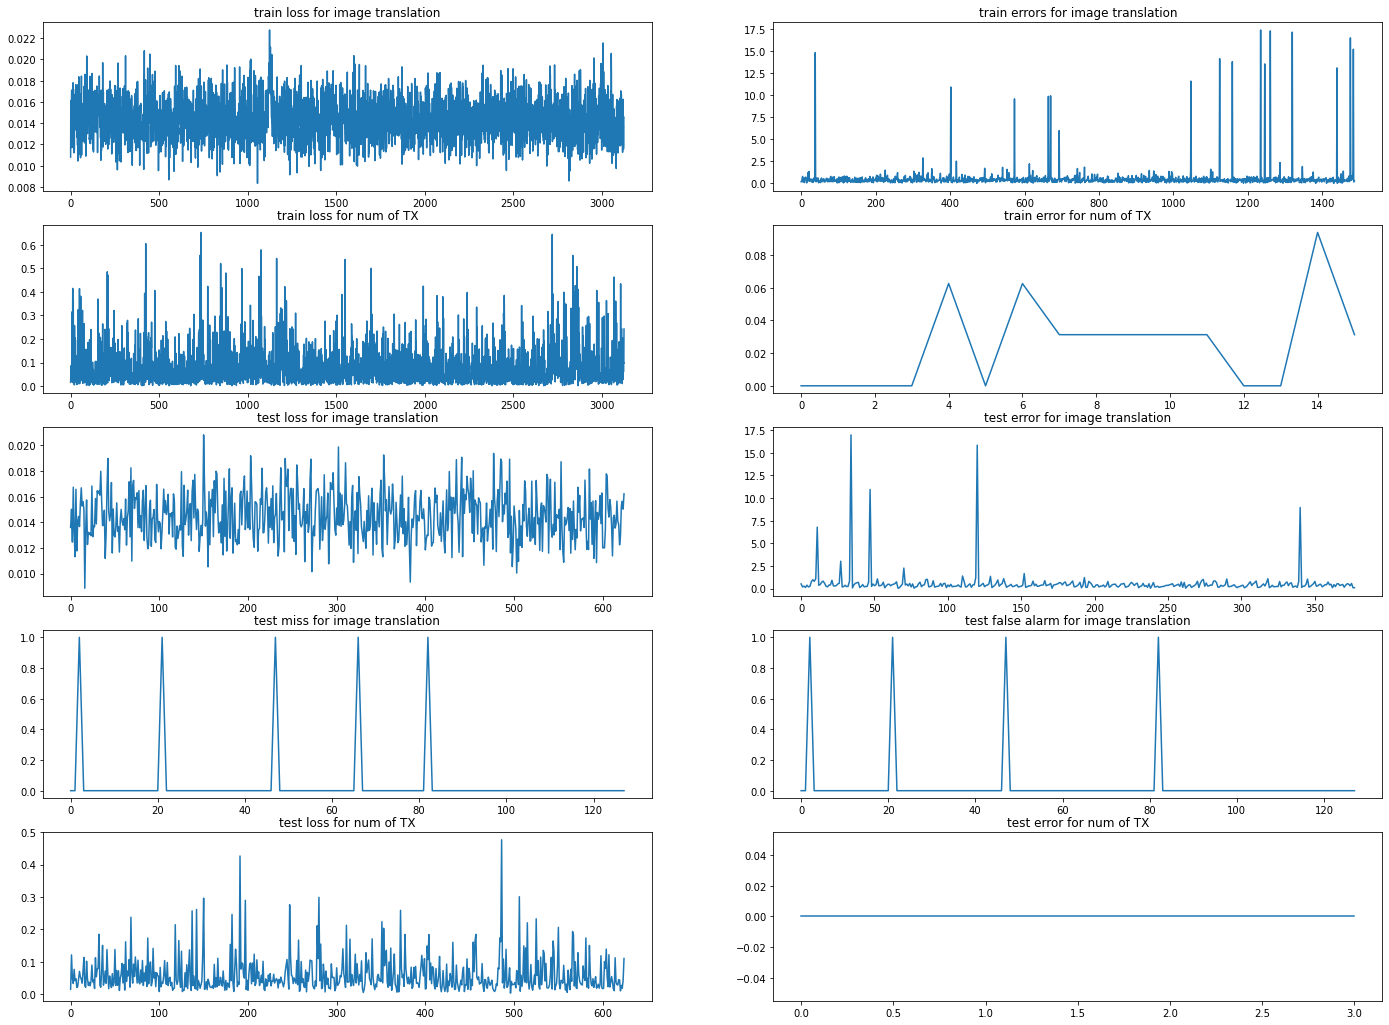

train loss of image translation  = 0.014337958295345307
train loss of num of TX          = 0.07904176604527981
test  loss of image translation  = 0.014503154267370701
test  loss of num of TX          = 0.059887668663263324
train error of image translation = 0.5477167451244116
train error of num of TX         = 0.025390625
test error of image translation  = 0.5695460317460317
test error of num of TX          = 0.0
test falses of image translation = 0.03125
test misses of image translation = 0.0390625
train loss for image translation
(0.022434478910565377, 0.004532589863470168)
(0.017396922272741793, 0.0021679275263283095)
(0.01618099789738655, 0.0020418057231238337)
(0.015592072357535363, 0.0020166255650755603)
(0.015201378872096539, 0.0019933270327613683)
(0.014922235023677349, 0.0019397759250995574)
(0.014711971940994262, 0.001943263118460935)
(0.014535952989161015, 0.0019272137324346263)
(0.014407585853040219, 0.001890108808007417)
(0.014337958295345307, 0.0019361671747789477)
train 

In [10]:
# %%time
# image translation problem
device     = torch.device('cuda')

max_ntx = 10
model1 = NetTranslation4()
model2 = NetNumTx(max_ntx)

model1     = model1.to(device)
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)
mse_loss   = nn.MSELoss()  # criterion is the loss function
l1_loss    = nn.L1Loss()

model2     = model2.to(device)
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)
cross_entro_loss = nn.CrossEntropyLoss()

num_epochs = 10
train_losses1_epoch, train_losses2_epoch = [], []
train_errors1_epoch, train_errors2_epoch = [], []
test_losses1_epoch,  test_losses2_epoch  = [], []
test_errors1_epoch,  test_errors2_epoch  = [], []
test_misses1_epoch,  test_falses1_epoch  = [], []
print_every = 200
error_every = 200
zeros  = make_zeros(batch=32, length=100)
alpha  = 0    # control regulation

for epoch in range(num_epochs):
    print(f'epoch = {epoch}')
    train_losses1, train_losses2 = [], []
    train_errors1, train_errors2 = [], []
    test_losses1, test_losses2   = [], []
    test_errors1, test_errors2   = [], []
    test_misses1  = []
    test_falses1  = []
    model1.train()
    model2.train()
    for t, sample in enumerate(sensor_input_dataloader):
        X = sample['matrix'].to(device)
        y = sample['target'].to(device)
        y_num   = sample['target_num'].to(device)
        y_num2  = np.array(sample['target_num'])
        y_float = np.array(sample['target_float'])
        y_float = my_uncollate(y_num2, y_float)
        indx = sample['index']

        pred_matrix = model1(X)              # the model for iamge translation
        loss_matrix = mse_loss(pred_matrix, y)
        regulation  = l1_loss(pred_matrix, zeros)
        loss1 = loss_matrix + alpha*regulation
        optimizer1.zero_grad()
        loss1.backward()
        optimizer1.step()

        pred_ntx    = model2(X)              # the model for num TX
        loss2 = cross_entro_loss(pred_ntx, y_num-1)  # 1 TX is class 0, 2 TX is class 1
        optimizer2.zero_grad()
        loss2.backward()
        optimizer2.step()

        train_losses1.append(loss1.item())
        train_losses2.append(loss2.item())
        pred_matrix = pred_matrix.data.cpu().numpy()
        _, pred_ntx = pred_ntx.data.cpu().max(1)
        pred_ntx = (pred_ntx+1).numpy()    # class 0 means 1 TX, class 1 means 2 TX etc...
        if t % error_every == 0:
            errors, misses, falses = Metrics.localization_error_image_continuous(pred_matrix, pred_ntx, y_float, indx, Default.grid_length)
            train_errors1.extend(errors)
            num_correct = (pred_ntx == y_num2).sum()
            total = len(pred_ntx)
            train_errors2.append(1 - num_correct*1.0/total)
        if t % print_every == 0:
            print(f't = {t}, loss_matrix = {loss_matrix.item()}, loss_num_tx = {loss2.item()}, regulation = {regulation.item()}')

    model1.eval()
    model2.eval()
    for t, sample in enumerate(sensor_input_test_dataloader):
        X = sample['matrix'].to(device)
        y = sample['target'].to(device)
        y_num   = sample['target_num'].to(device)
        y_num2  = np.array(sample['target_num'])
        y_float = np.array(sample['target_float'])
        y_float = my_uncollate(y_num2, y_float)
        indx = sample['index']

        pred_matrix = model1(X)              # the model for iamge translation
        loss_matrix = mse_loss(pred_matrix, y)
        regulation  = l1_loss(pred_matrix, zeros)
        loss1 = loss_matrix + alpha*regulation

        pred_ntx    = model2(X)              # the model for num TX
        loss2 = cross_entro_loss(pred_ntx, y_num-1)  # 1 TX is class 0, 2 TX is class 1

        test_losses1.append(loss1.item())
        test_losses2.append(loss2.item())
        pred_matrix = pred_matrix.data.cpu().numpy()
        _, pred_ntx = pred_ntx.data.cpu().max(1)
        pred_ntx = (pred_ntx+1).numpy()    # class 0 means 1 TX, class 1 means 2 TX etc...
        if t % error_every == 0:
            errors, misses, falses = Metrics.localization_error_image_continuous(pred_matrix, pred_ntx, y_float, indx, Default.grid_length)
            test_errors1.extend(errors)
            test_misses1.extend(misses)
            test_falses1.extend(falses)
            num_correct = (pred_ntx == y_num2).sum()
            total = len(pred_ntx)
            test_errors2.append(1 - num_correct*1.0/total)
    plot_epoch_stats(train_losses1, train_losses2, train_errors1, train_errors2, test_losses1, test_losses2, test_errors1, test_errors2, test_misses1, test_falses1)

print('train loss for image translation')
for loss in train_losses1_epoch:
    print(loss)
print('train loss for num of TX')
for loss in train_losses2_epoch:
    print(loss)
print('train error for image translation')
for error in train_errors1_epoch:
    print(error)
print('train error for num of TX')
for error in train_errors2_epoch:
    print(error)
print('test loss for image translation')
for loss in test_losses1_epoch:
    print(loss)
print('test loss for num of TX')
for loss in test_losses2_epoch:
    print(loss)
print('test error for image translation')
for error in test_errors1_epoch:
    print(error)
print('test error for num of TX')
for error in test_errors2_epoch:
    print(error)
print('test misses for image translation')
for miss in test_misses1_epoch:
    print(miss)
print('test falses for image translation')
for false in test_falses1_epoch:
    print(false)

In [11]:
# evaluation for all test samples

test_index, test_errors1, test_misses1, test_falses1 = [], [], [], []
num_correct, num_total = 0, 0

model1.eval()
model2.eval()
for t, sample in enumerate(sensor_input_test_dataloader):
    if t % 10 == 9:
        print(t, end='')
    X = sample['matrix'].to(device)
    y = sample['target'].to(device)
    y_num   = sample['target_num'].to(device)
    y_num2  = np.array(sample['target_num'])
    y_float = np.array(sample['target_float'])
    y_float = my_uncollate(y_num2, y_float)
    indx = sample['index']

    pred_matrix = model1(X)              # the model for iamge translation
    pred_ntx    = model2(X)              # the model for num TX

    pred_matrix = pred_matrix.data.cpu().numpy()
    _, pred_ntx = pred_ntx.data.cpu().max(1)
    pred_ntx = (pred_ntx+1).numpy()      # class 0 means 1 TX, class 1 means 2 TX etc...

    errors, misses, falses = Metrics.localization_error_image_continuous(pred_matrix, pred_ntx, y_float, indx, Default.grid_length)
    test_errors1.extend(errors)
    test_misses1.extend(misses)
    test_falses1.extend(falses)
    test_index.extend(indx.numpy())
    num_correct += (pred_ntx == y_num2).sum()
    num_total += len(pred_ntx)

print()
test_errors1_tmp = [val for sublist in test_errors1 for val in sublist]
print('error', np.mean(test_errors1_tmp), np.std(test_errors1_tmp))
print('miss ', np.mean(test_misses1), np.std(test_misses1))
print('false', np.mean(test_falses1), np.std(test_falses1))
print('Num of TX prediction accuracy = {}'.format(num_correct*1.0/num_total))


9
19
29
39
49
59
69
79
89
99
109
119
129
139
149
159
169
179
189
199
209
219
229
239
249
259
269
279
289
299
309
319
329
339
349
359
369
379
389
399
409
419
429
439
449
459
469
479
489
499
509
519
529
539
549
559
569
579
589
599
609
619

error 0.5313209458998499 1.3232277103002694
miss  0.07215 0.2635230113291816
false 0.04755 0.21351580152297867
Num of TX prediction accuracy = 0.9834


In [13]:
# OBSERVATION: big errors happens in the edge and corners.

for indx, errors, miss, false in zip(test_index, test_errors, test_misses, test_falses):
    if max(errors) > 3 or miss > 0 or false > 0:
        print(indx, errors, miss, false)

977 [0.2496, 12.1932] 0 0
19824 [0.3258] 1 0
11368 [0.2633] 1 0
18782 [1.3831, 13.3894] 0 0
10083 [0.7158, 12.3542] 0 0
14900 [0.1621, 13.5345] 0 0
5785 [0.9813] 1 0
4888 [0.5369, 6.3445] 0 0
15549 [0.3587, 12.713] 0 0
4109 [0.7079, 16.138] 0 0
3730 [1.2951, 8.1183] 0 0
12882 [0.6515, 10.4055] 0 0
5594 [0.8726, 8.2959] 0 0
7403 [1.2535, 10.316] 0 0
7962 [0.5189, 7.6124] 0 0
9572 [1.3827, 13.431] 0 0
12043 [0.3887, 10.9694] 0 0
8329 [0.205, 10.8616] 0 0
15922 [0.3454, 9.3949] 0 0
3415 [0.0127, 11.4417] 0 0
16340 [0.2986, 14.9793] 0 0
7616 [0.56, 8.3817] 0 0
10005 [0.505] 1 0
18056 [1.8772] 1 0
7221 [1.2482, 9.4152] 0 0
12298 [0.5027, 8.3651] 0 0
8992 [1.0007, 7.4849] 0 0
10908 [0.3836] 1 0
10065 [0.3094, 13.2885] 0 0
8934 [0.2118, 5.2948] 0 0
15130 [1.6757, 8.3572] 0 0
7310 [0.2663, 10.5104] 0 0
12588 [0.8585] 1 0
19780 [1.3151, 10.0109] 0 0
14702 [0.6747] 1 0
10303 [0.3268, 10.1875] 0 0
11382 [4.5833] 1 0
7428 [0.1589, 7.0429] 0 0
5778 [1.0475] 1 1
3493 [0.2789] 1 0
14672 [0.5901, 11.3

In [68]:
# folder = '2TXupbound-20-min-dist'
# np.savetxt(f'result/{folder}/train_losses1.txt', test_losses1_epoch)
# np.savetxt(f'result/{folder}/train_errors.txt', test_losses2_epoch)
# np.savetxt(f'result/{folder}/test_loss.txt', test_errors1_epoch)
# np.savetxt(f'result/{folder}/test_errors.txt', test_errors2_epoch)
# np.savetxt(f'result/{folder}/test_misses.txt', test_misses1_epoch)
# np.savetxt(f'result/{folder}/test_falses.txt', test_falses1_epoch)

In [12]:
def myplot(X, pred, pred_n, y, indx, i):
    fig, axs = plt.subplots(1, 3, figsize=(30, 8))
    sns.heatmap(X[0], cmap='gray', annot=False, ax=axs[0])
    sns.heatmap(pred[0], cmap='gray', annot=False, ax=axs[1])
    sns.heatmap(y[0], cmap='gray', annot=False, ax=axs[2])
    axs[0].set_title(f'{indx} - {i}')
    axs[1].set_title(f'# of predict TX {pred_n:.2f}')
    fig.tight_layout()

def myplot2(pred, y, y_float):
    '''
    Args:
        pred    -- array like -- 2d dimension pred matrix
        y       -- array like -- 2d dimension true matrix
        y_float -- array like -- (2, 2), first 2 is the number of TX, second 2 means a pair of (x, y)
    '''
    print(y_float)
    fig, axs = plt.subplots(1, 4, figsize=(24, 5))
    for i in range(len(y_float)):
        a, b = y_float[i]
        a, b = int(a), int(b)
        a1 = a-5 if a >= 5 else 0
        a2 = a+5 if a <= Default.grid_length-5 else Default.grid_length
        b1 = b-5 if b >= 5 else 0
        b2 = b+5 if b <= Default.grid_length-5 else Default.grid_length
        print(f'pred {i} ({a1}, {a2}), ({b1}, {b2})')
        sns.heatmap(pred[a1:a2,b1:b2], cmap='gray', annot=True, ax=axs[i])
        axs[i].set_title(f'pred {i} ({a}, {b})')
    for i in range(len(y_float)):
        a, b = y_float[i]
        a, b = int(a), int(b)
        a1 = a-5 if a >= 5 else 0
        a2 = a+5 if a <= Default.grid_length-5 else Default.grid_length
        b1 = b-5 if b >= 5 else 0
        b2 = b+5 if b <= Default.grid_length-5 else Default.grid_length
        print(f'y    {i} ({a1}, {a2}), ({b1}, {b2})')
        sns.heatmap(y[a1:a2, b1:b2], cmap='gray', annot=True, ax=axs[i+2])
        axs[i+2].set_title(f'y   {i} ({a}, {b})')
    fig.tight_layout()

loss matrix = 0.0088351434096694
loss num tx = 0.0
pred ntx [1]
0 16978 pred [(84.51, 87.53)] ; truth [(84.92, 89.97)]  ; error [2.4717]  ; miss 0  ; false 0
[[84.91791 89.96539]]
pred 0 (79, 89), (84, 94)
y    0 (79, 89), (84, 94)


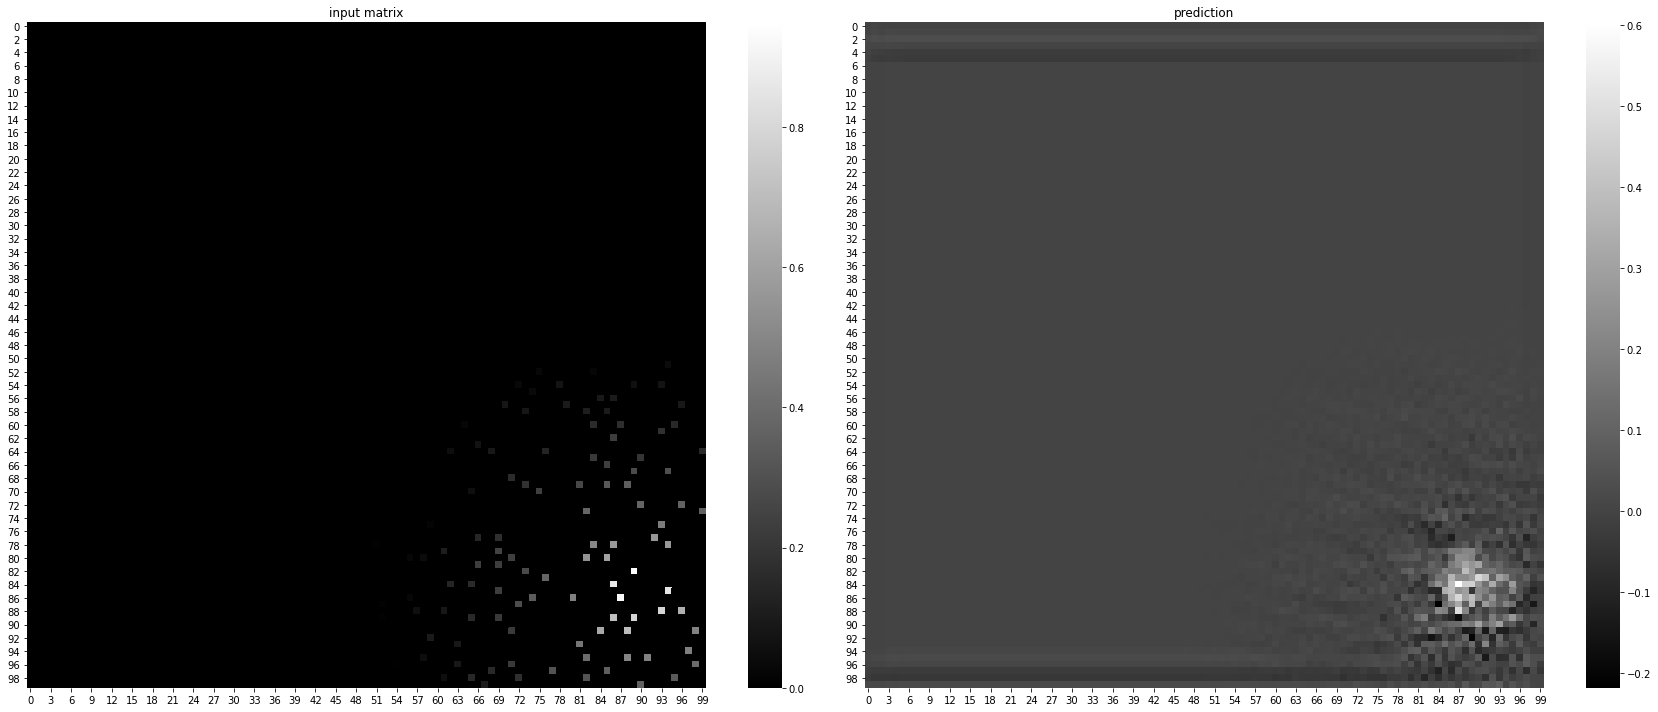

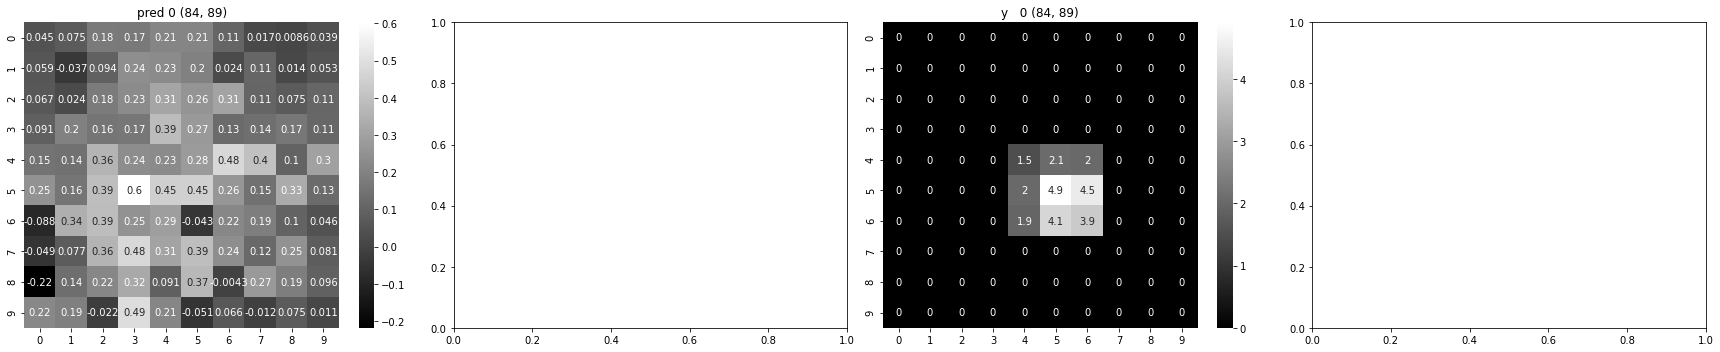

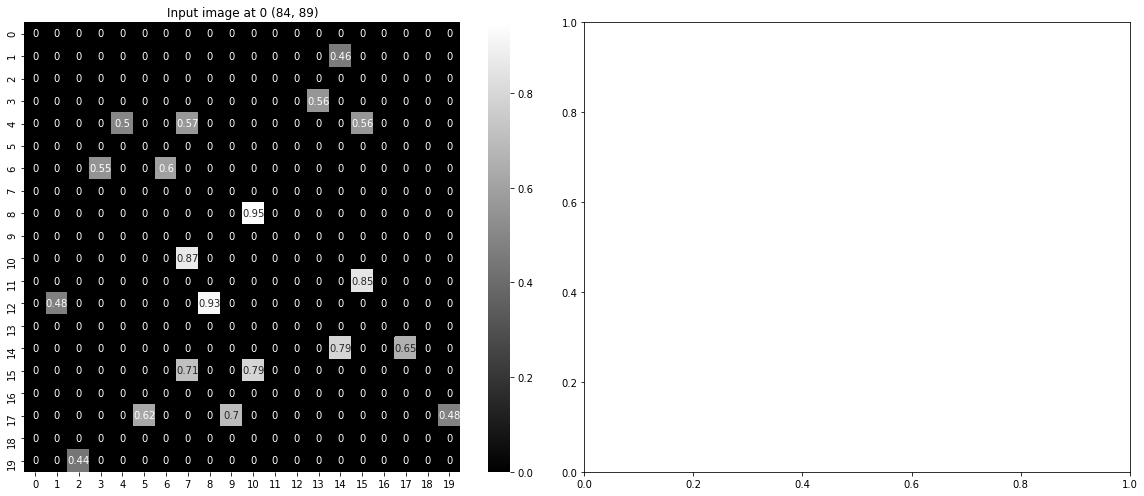

In [15]:
# Test for one sample

# idx = 12646     # typical one
# idx = 1511
# idx = 12093
# idx = 15594
# idx = 19323
# idx = 18909
# idx = 5434
idx = 9142
idx = 10934
idx = 9789
idx = 3370
idx = 8357
idx = 16978

def one_sample(idx):
    device = torch.device('cuda')
    model.eval()
    sample = sensor_input_test_dataset[idx]
    X = torch.as_tensor(sample['matrix'])
    X = X.unsqueeze(0).to(device)            # increase dimension to a batch
    y = torch.as_tensor(sample['target'])
    y = y.unsqueeze(0).to(device)            # increase dimension to a batch
    y_num = torch.as_tensor(sample['target_num'])
    y_num = y_num.unsqueeze(0).to(device)    # increase dimension to a batch
    y_f = np.expand_dims(sample['target_float'], 0)
    indx = np.expand_dims(np.array(sample['index']), 0)

    pred_matrix, pred_ntx = model(X)

    loss_matrix = criterion1(pred_matrix, y)
    loss_num_tx = criterion2(pred_ntx, y_num-1)
    print('loss matrix =', loss_matrix.item())
    print('loss num tx =', loss_num_tx.item())

    pred_matrix = pred_matrix.data.cpu().numpy()
    _, pred_ntx = pred_ntx.data.cpu().max(1)
    pred_ntx = (pred_ntx+1).numpy()    # class 0 means 1 TX, class 1 means 2 TX etc...
    print('pred ntx', pred_ntx)
    errors, misses, falses = Metrics.localization_error_image_continuous(pred_matrix.copy(), pred_ntx, y_f, indx, Default.grid_length, debug=True)

    pred_matrix = pred_matrix[0][0]
    fig, axs = plt.subplots(1, 2, figsize=(24, 10))
    X = X[0][0].data.cpu().numpy()
    sns.heatmap(X, cmap='gray', ax=axs[0])
    axs[0].set_title('input matrix')
    sns.heatmap(pred_matrix, cmap='gray', ax=axs[1])
    axs[1].set_title('prediction')
    plt.tight_layout()
    np.savetxt('test.txt', pred_matrix)
    y = y.data.cpu().numpy()[0][0]
    y_f = y_f[0]
    myplot2(pred_matrix, y, y_f)

    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    for i in range(len(y_f)):
        a, b = y_f[i]
        a, b = int(a), int(b)
        a1 = a-10 if a >= 10 else 0
        a2 = a+10 if a <= Default.grid_length-10 else Default.grid_length
        b1 = b-10 if b >= 10 else 0
        b2 = b+10 if b <= Default.grid_length-10 else Default.grid_length
        sns.heatmap(X[a1:a2,b1:b2], cmap='gray', annot=True, ax=axes[i])
        axes[i].set_title(f'Input image at {i} ({a}, {b})')
    fig.tight_layout()


#     fig, ax = plt.subplots(figsize=(5.5, 5))
#     sns.heatmap(pred_matrix[:5, :5], cmap='gray', ax=ax, annot=True)
#     print('mean of top left 25', np.sum(np.abs(pred_matrix[:5, :5])))

one_sample(idx)

In [11]:
# Test for one random batch
plt.rcParams.update({'figure.max_open_warning': 0})
CUDA_LAUNCH_BLOCKING="1"

criterion1 = nn.MSELoss()
criterion2 = nn.CrossEntropyLoss()

model.eval()
for t, sample in enumerate(sensor_input_test_dataloader):
    X = sample['matrix'].to(device)
    y = sample['target'].to(device)
    y_num = sample['target_num'].to(device)
    y_num2  = np.array(sample['target_num'])
    y_float = np.array(sample['target_float'])
    y_float = my_uncollate(y_num2, y_float)
    indx = np.array(sample['index'])
    
    pred_matrix, pred_ntx = model(X)
    
    loss_matrix = criterion1(pred_matrix, y)
    loss_num    = criterion2(pred_ntx, y_num-1)
    print('loss matrix =', loss_matrix.item())
    print('loss num    =', loss_num.item())
    
    losses = []
    for i, pred, yy in zip(range(len(y)), pred_matrix, y):
        pred, yy = pred[0].data.cpu().numpy(), yy[0].data.cpu().numpy()
        loss = Metrics.loss(pred, yy)
        losses.append((i, loss))
    losses.sort(key=lambda x:x[1])
    for idx, (i, loss) in enumerate(losses):
        print('{}: matrix loss = {}'.format(i, loss), end='   ')
        if idx % 4 == 3: 
            print()
    print()
    pred_matrix = pred_matrix.data.cpu().numpy()   # not using .numpy() will cause big issue
    _, pred_ntx = pred_ntx.data.cpu().max(1)
    pred_ntx = (pred_ntx+1).numpy()    # class 0 means 1 TX, class 1 means 2 TX etc...
    errors, misses, falses = Metrics.localization_error_image_continuous(pred_matrix, pred_ntx, y_float, indx, Default.grid_length, True)
    errors = [val for sublist in errors for val in sublist]
    print('error', np.mean(errors), np.std(errors))
    print('miss ', np.mean(misses), np.std(misses))
    print('false', np.mean(falses), np.std(misses))
    break

X    = X.data.cpu().numpy()
# pred_matrix = pred_matrix.data.cpu().numpy()
# pred_ntx = pred_ntx.data.cpu().numpy()
y    = y.data.cpu().numpy()
indx = sample['index']

loss matrix = 0.015543699264526367
loss num    = 7.197035301942378e-06
28: matrix loss = 0.006308576583862305   19: matrix loss = 0.007789429473876953   14: matrix loss = 0.008343038177490235   5: matrix loss = 0.008484288787841797   
22: matrix loss = 0.008835143280029297   1: matrix loss = 0.009090017700195312   10: matrix loss = 0.009112877655029297   11: matrix loss = 0.009805565643310548   
21: matrix loss = 0.009867320251464844   17: matrix loss = 0.009886075592041016   4: matrix loss = 0.01066738510131836   23: matrix loss = 0.010747147369384766   
20: matrix loss = 0.010855002593994141   15: matrix loss = 0.011396515655517579   26: matrix loss = 0.011996070861816406   31: matrix loss = 0.012977761840820312   
0: matrix loss = 0.013457986450195313   8: matrix loss = 0.014129356384277343   12: matrix loss = 0.01667904052734375   16: matrix loss = 0.0167550048828125   
18: matrix loss = 0.01688486785888672   24: matrix loss = 0.0169642578125   13: matrix loss = 0.01768681793212890

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 

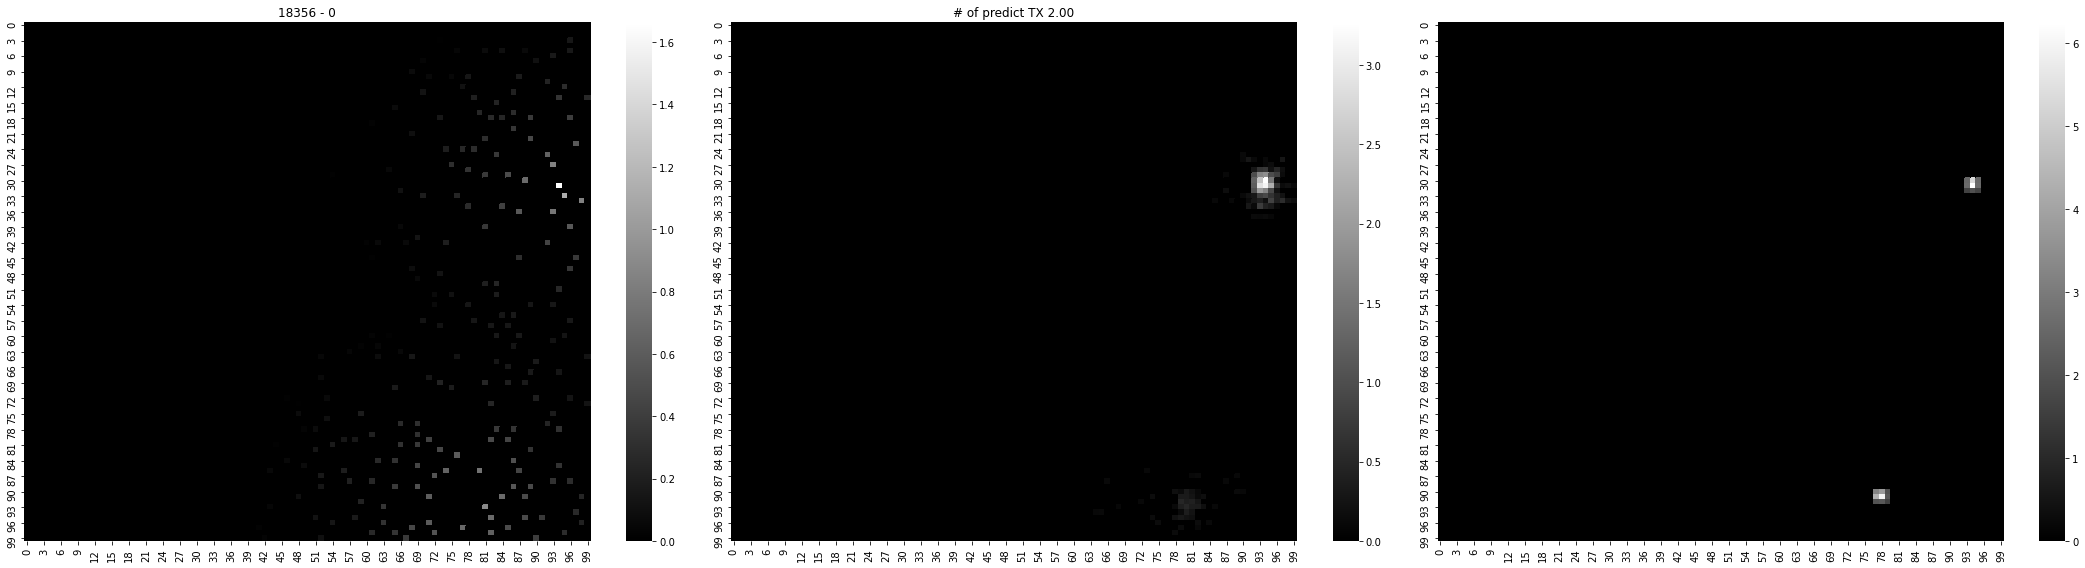

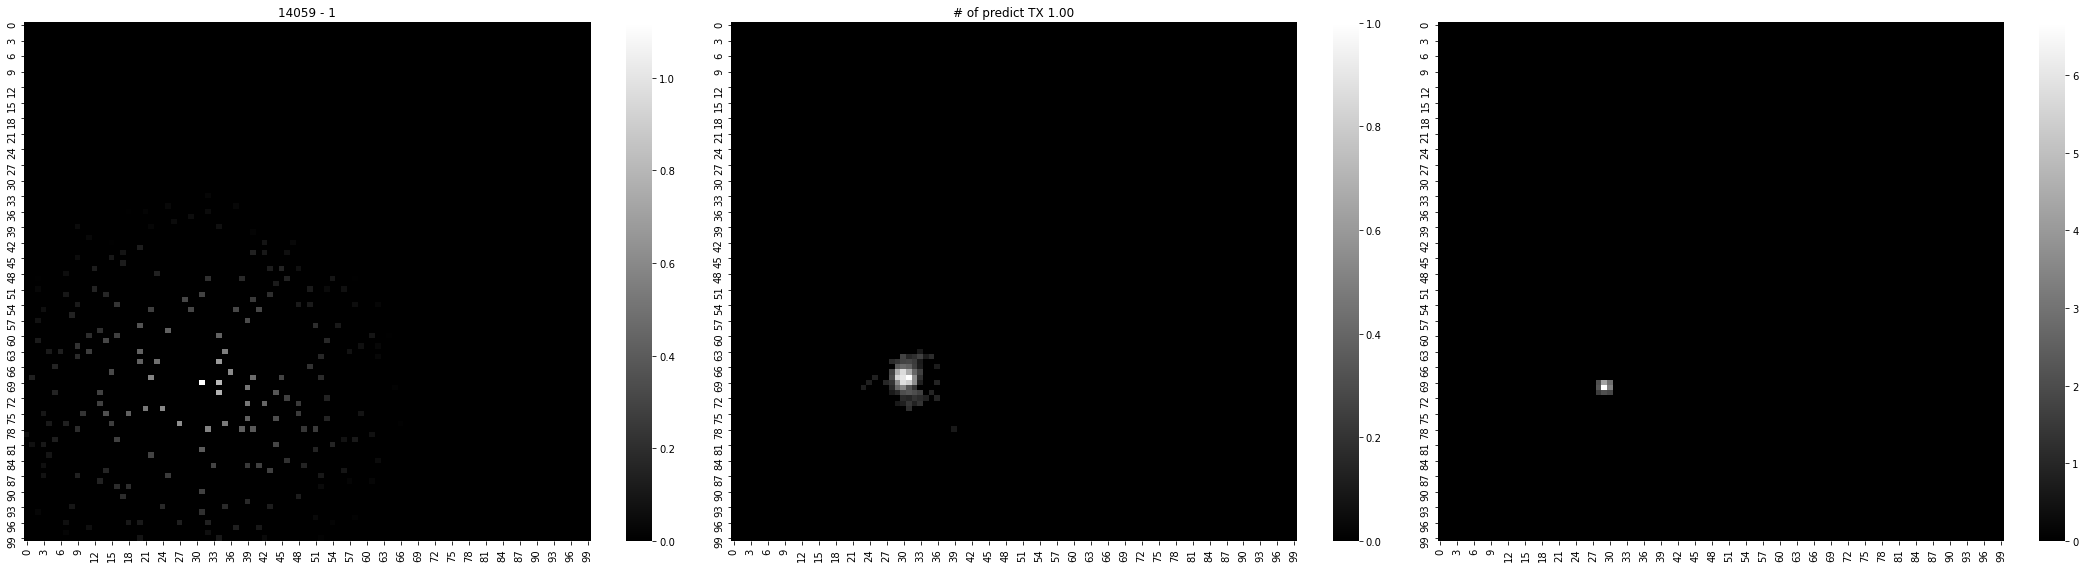

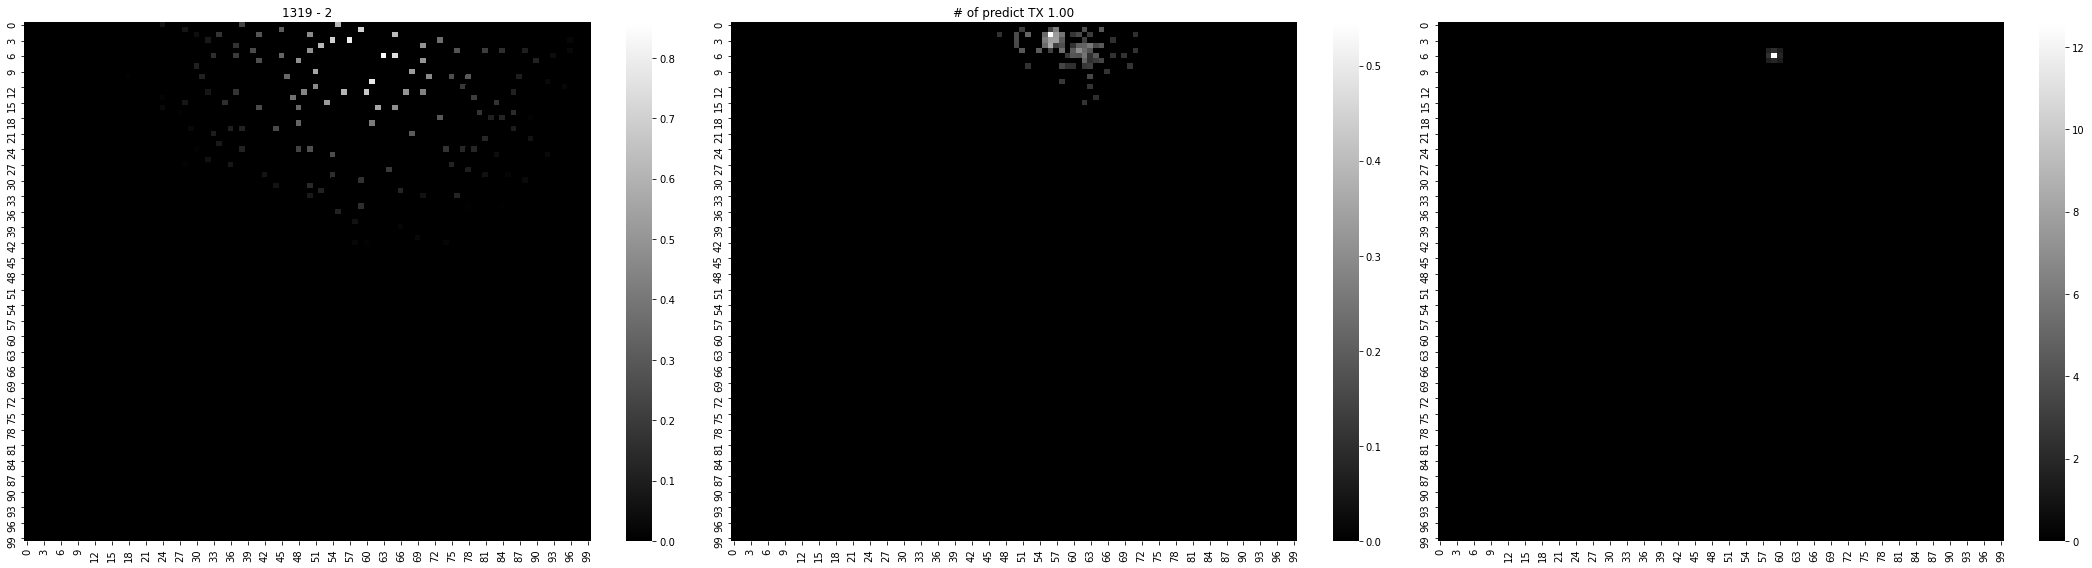

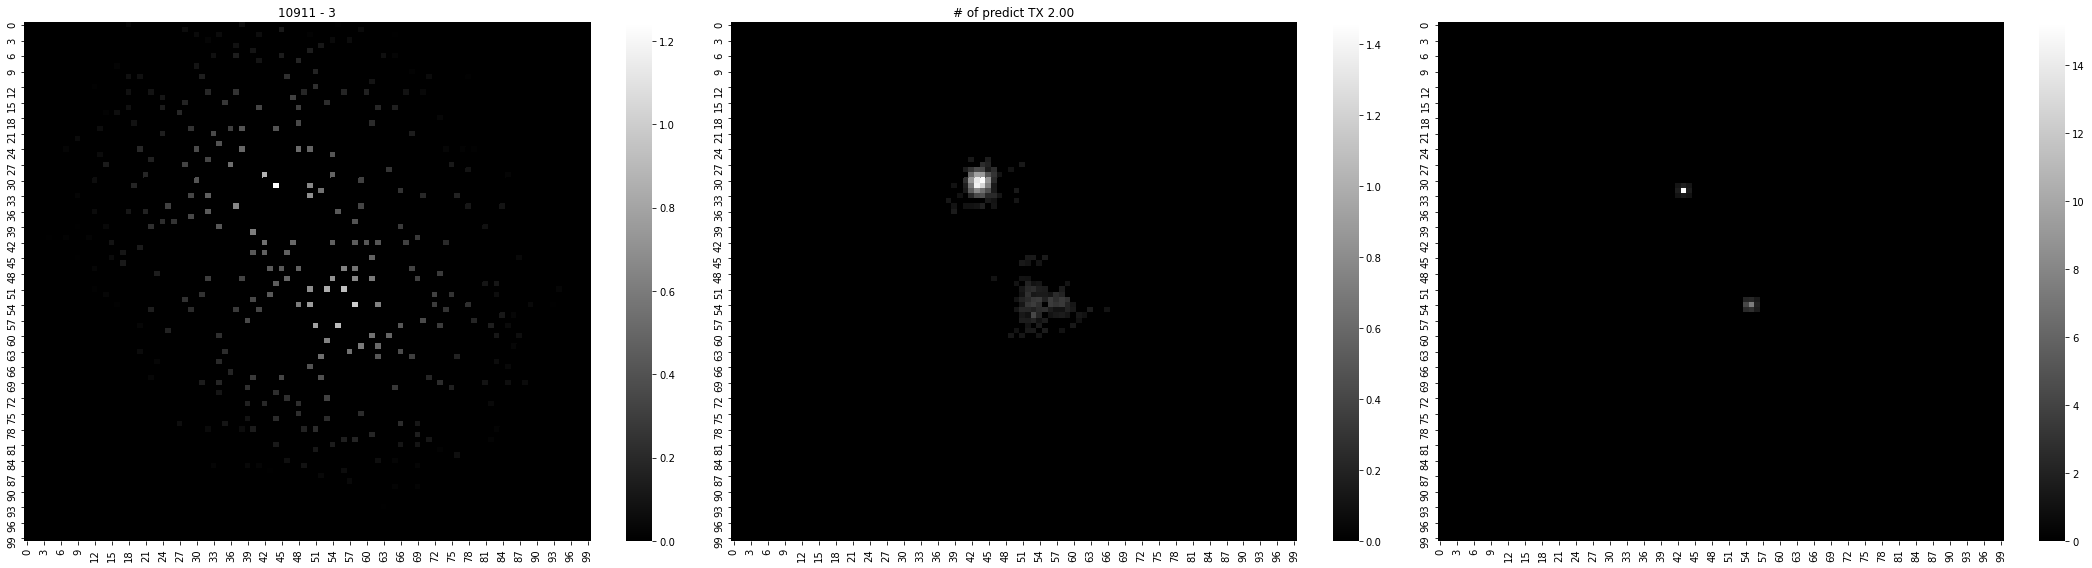

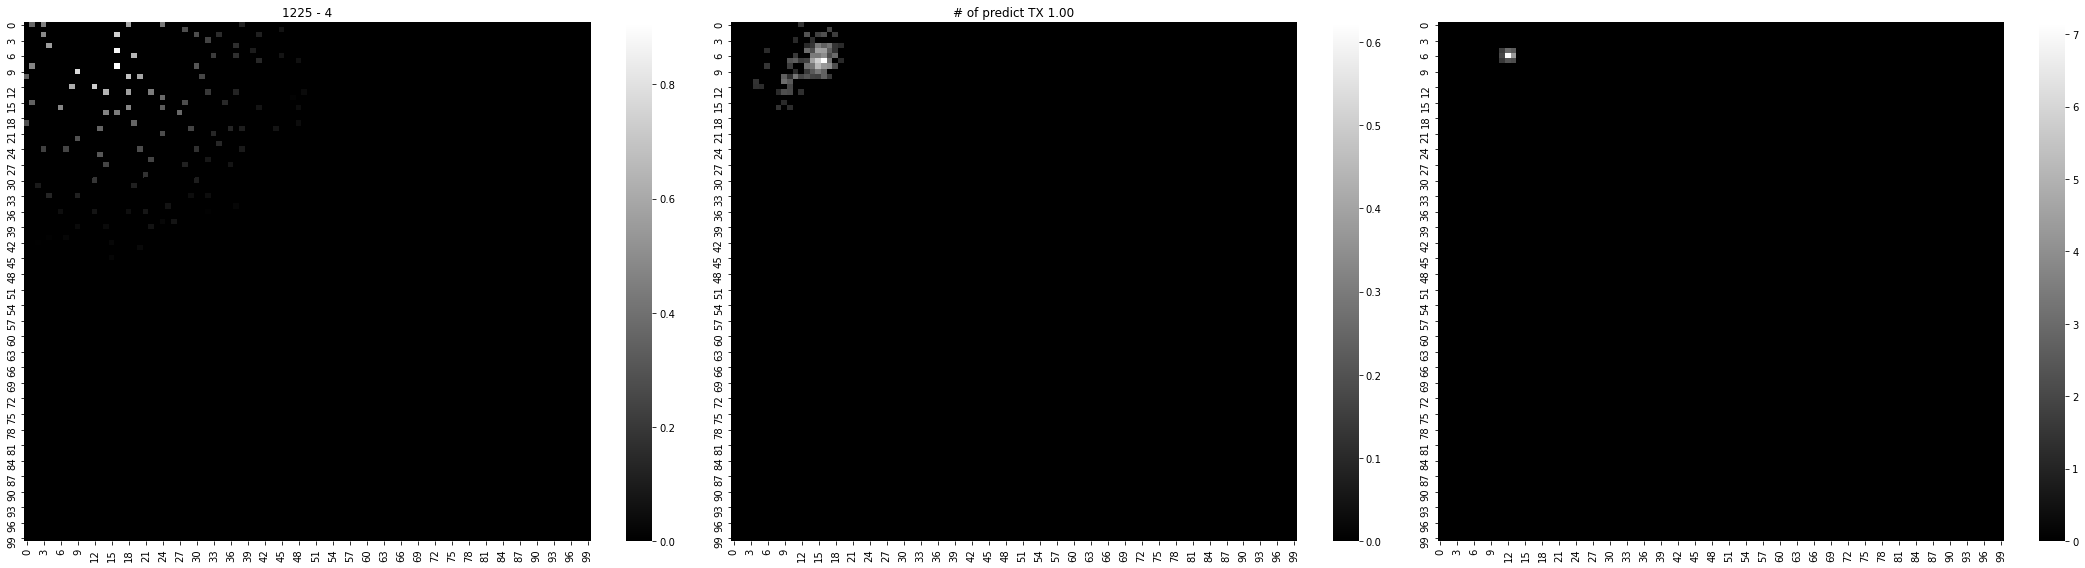

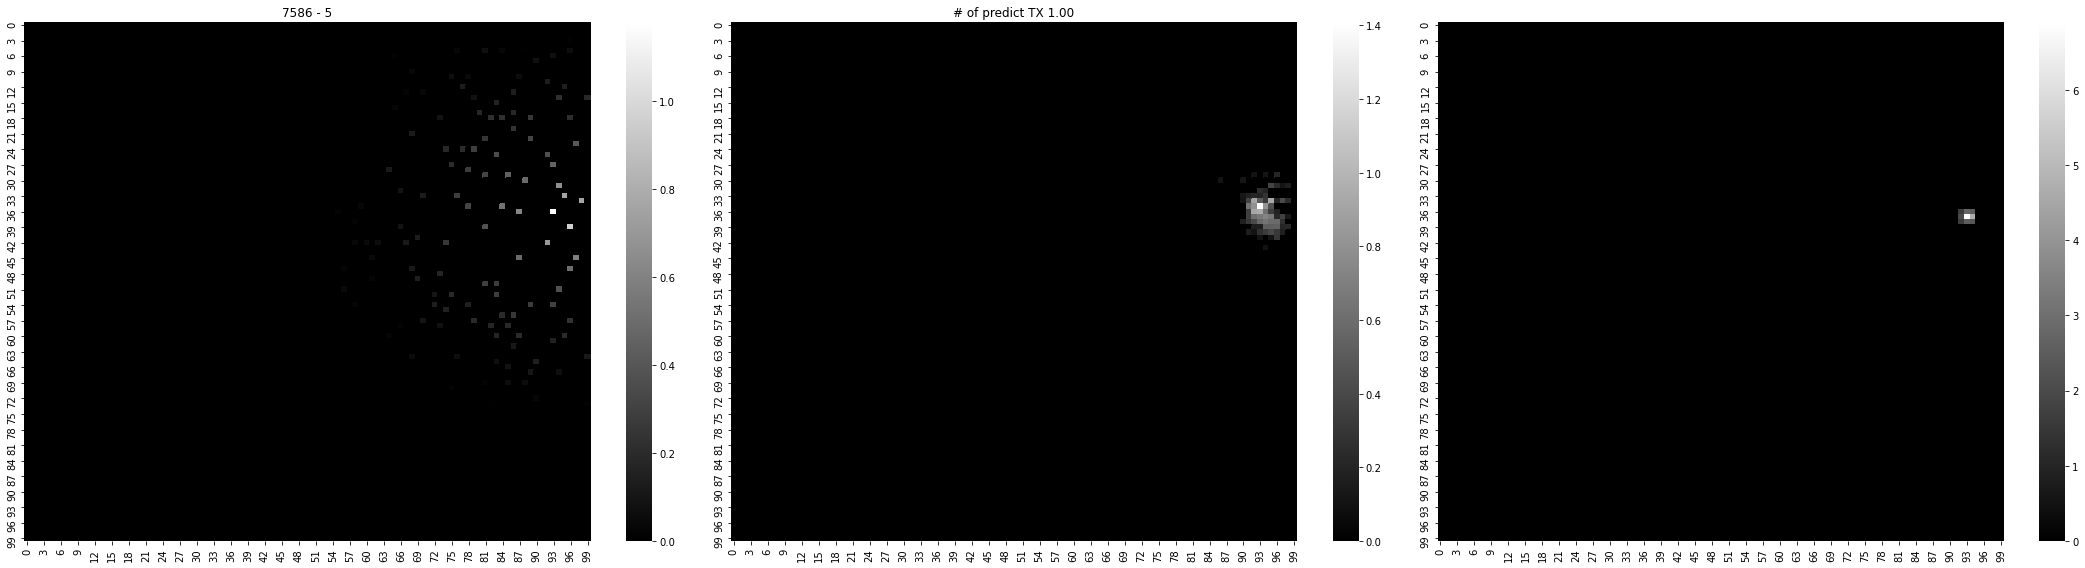

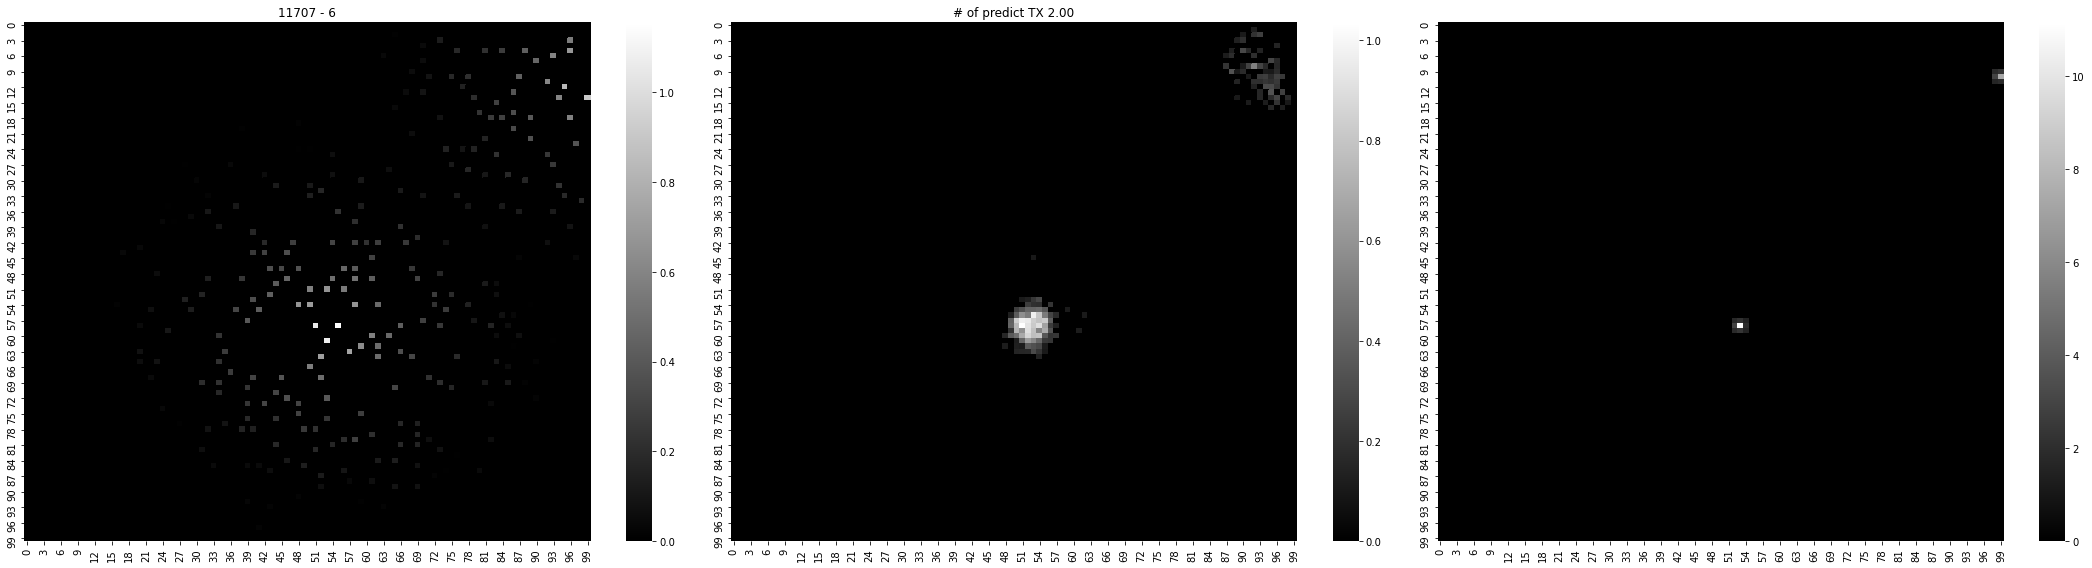

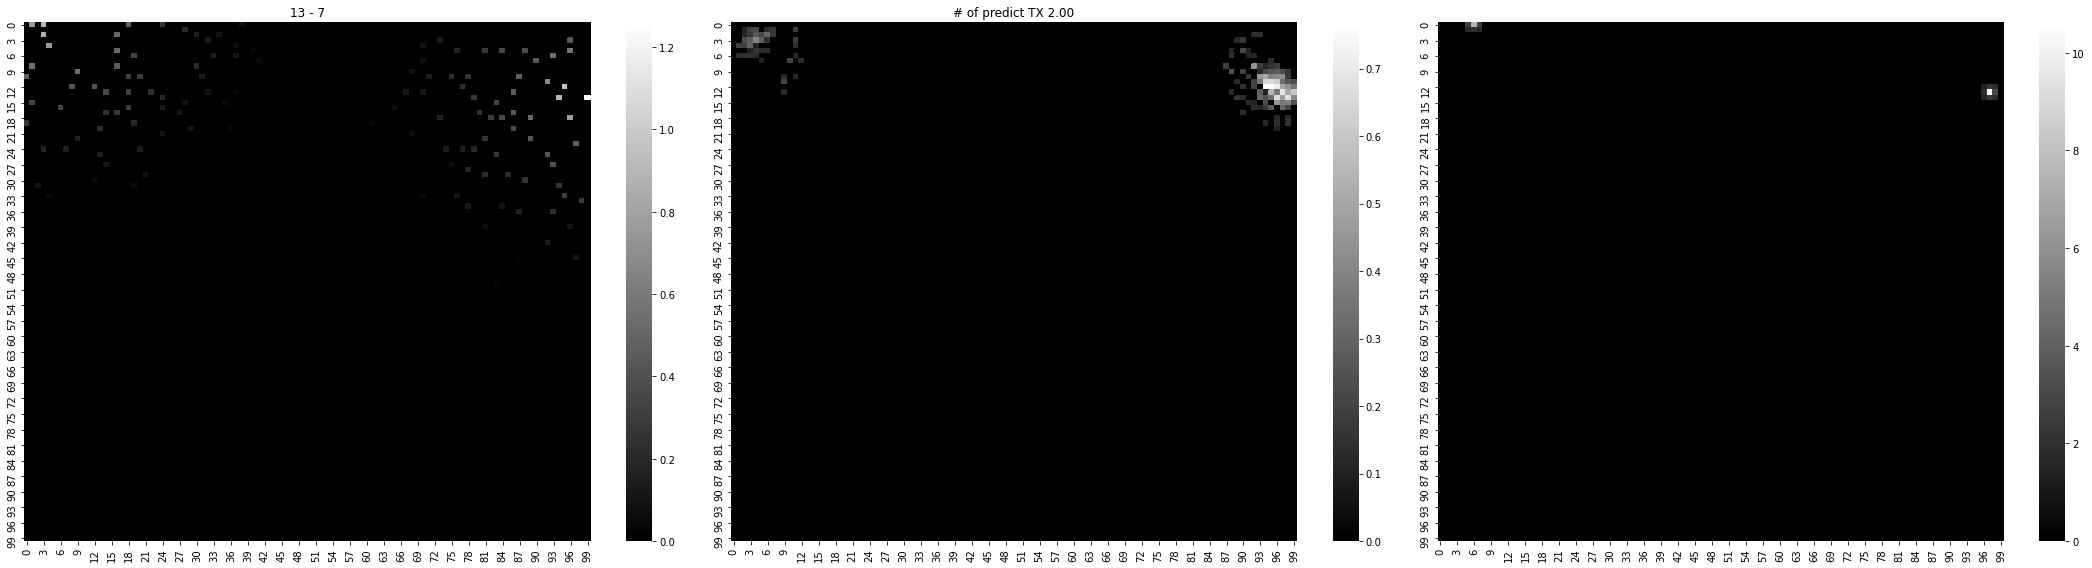

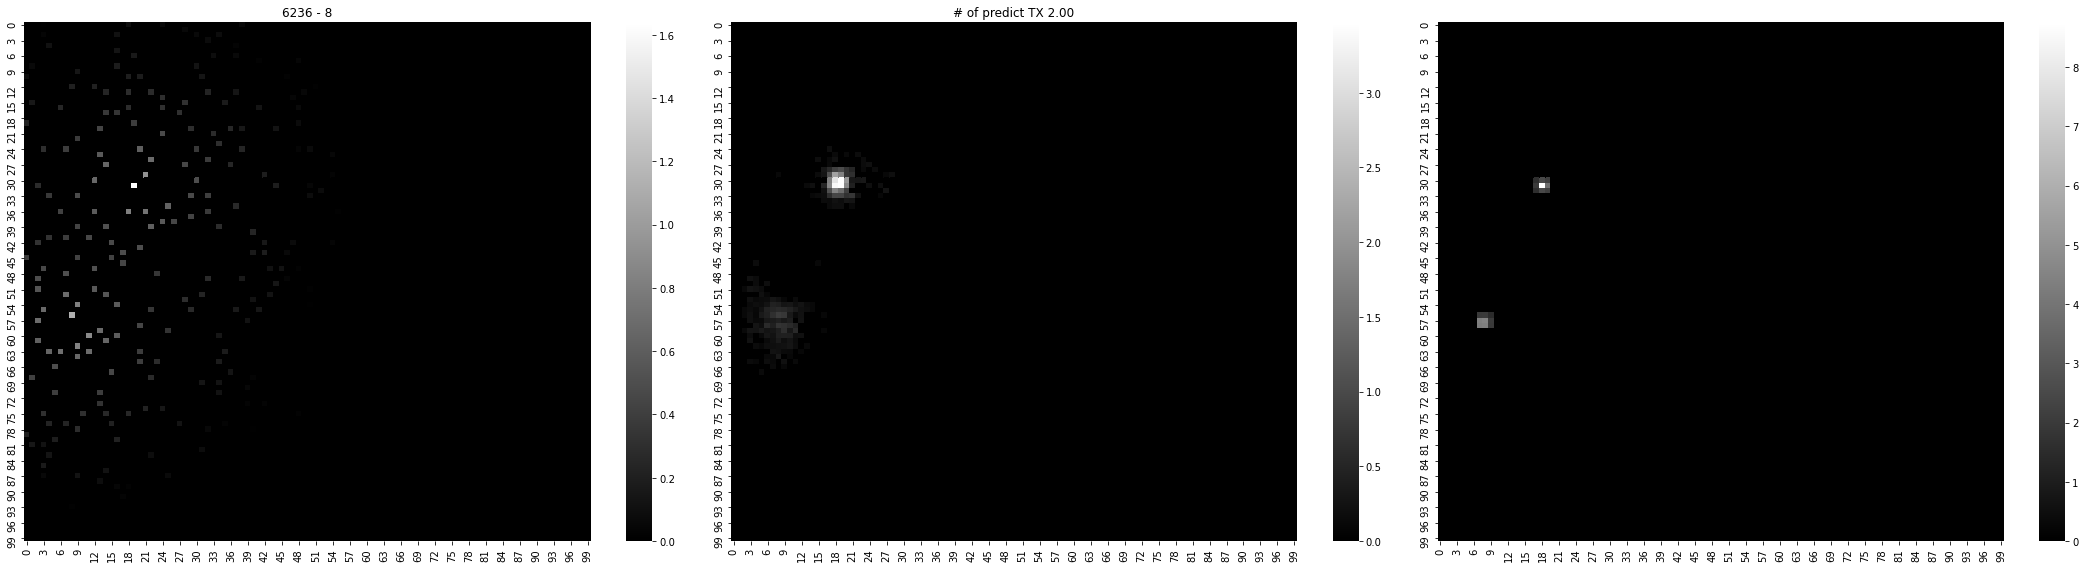

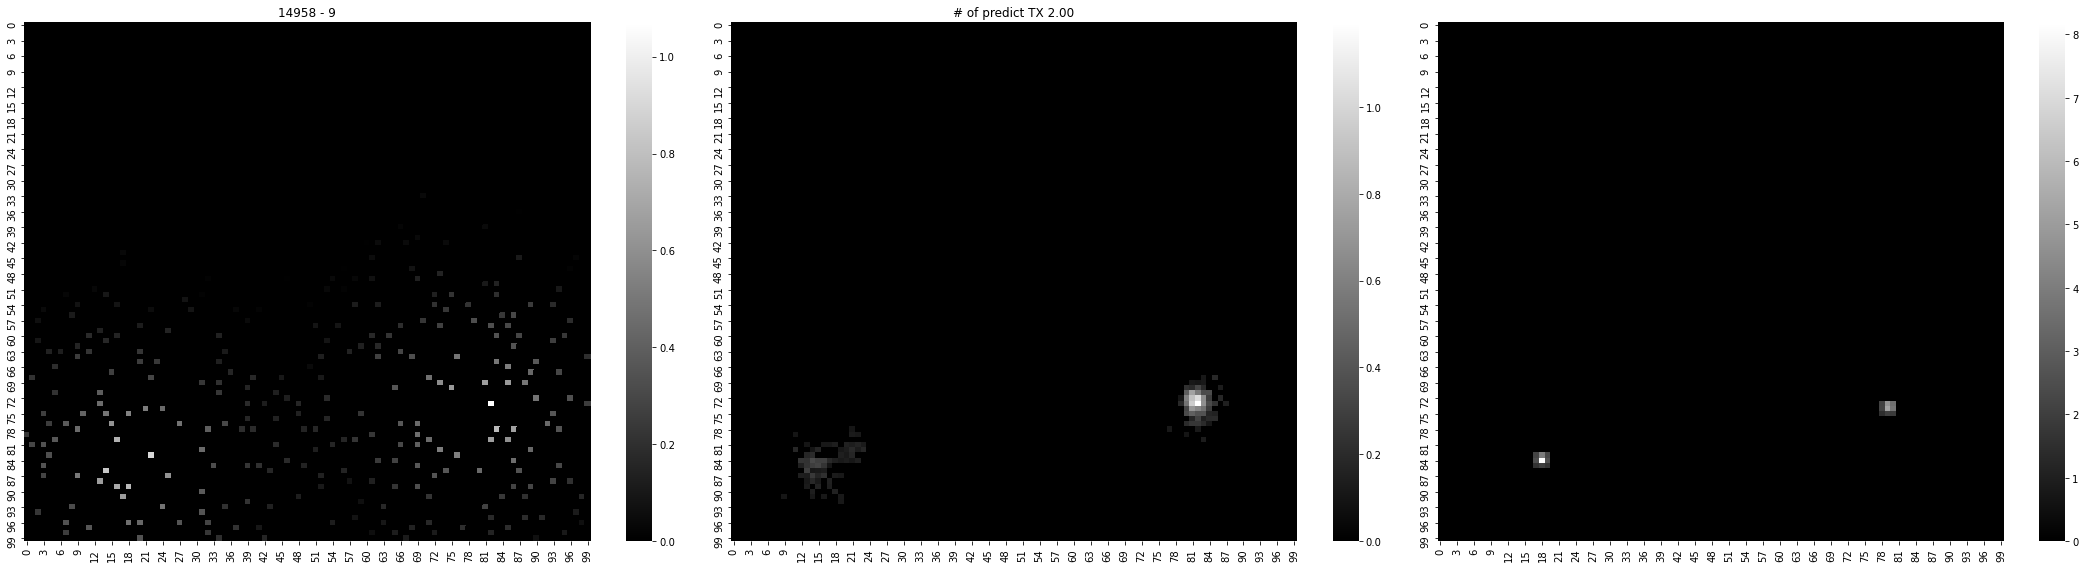

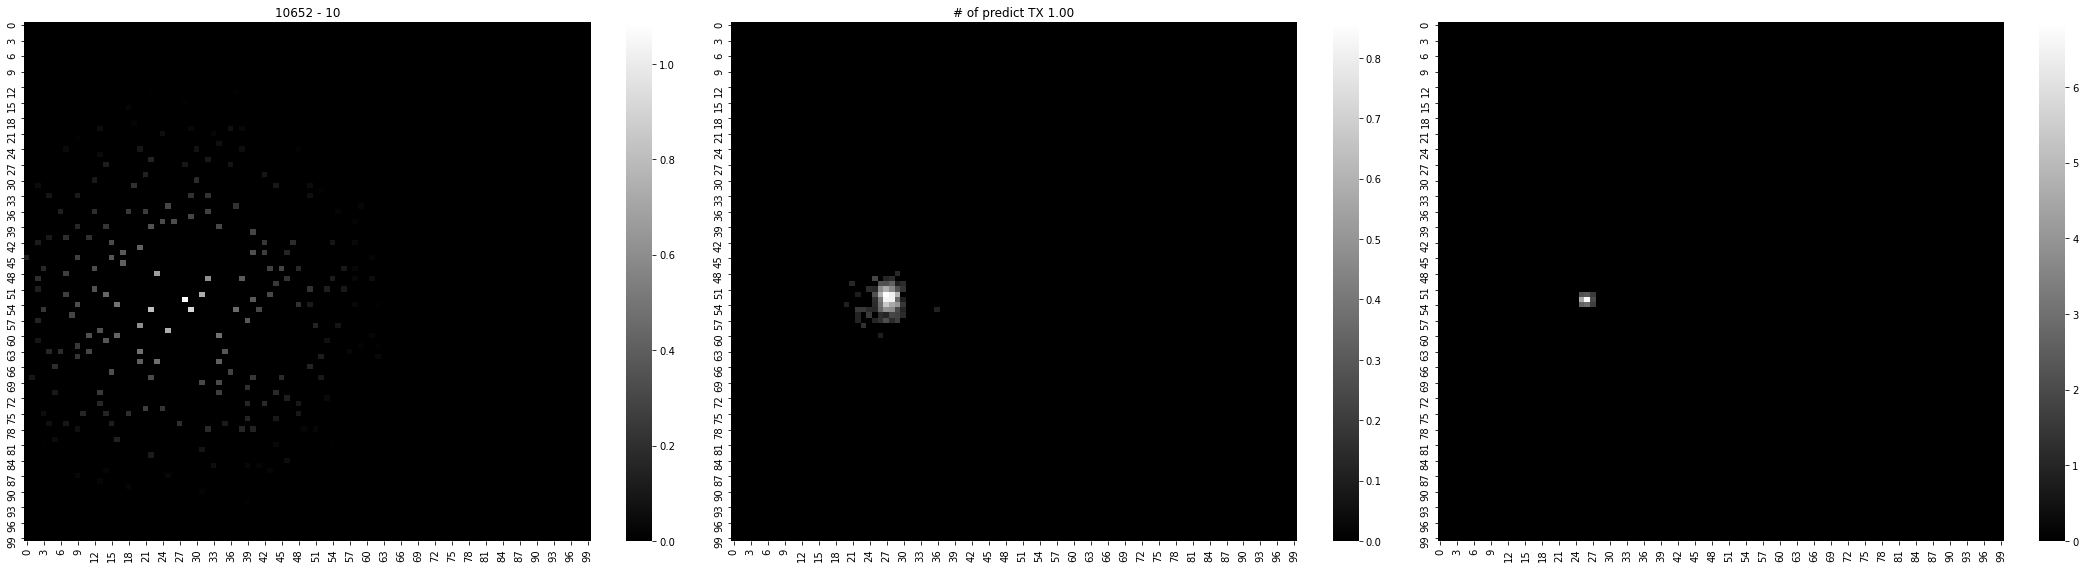

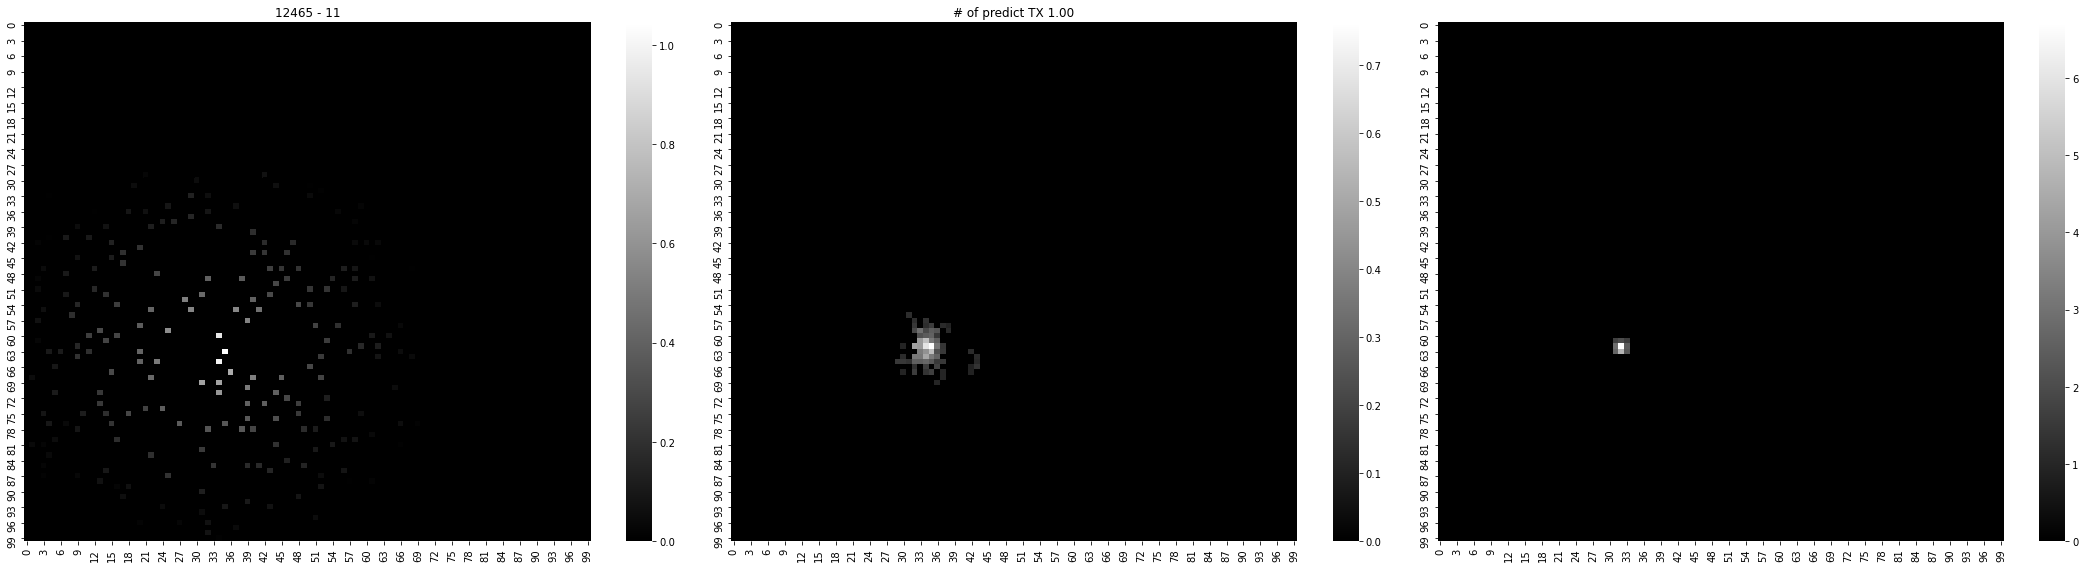

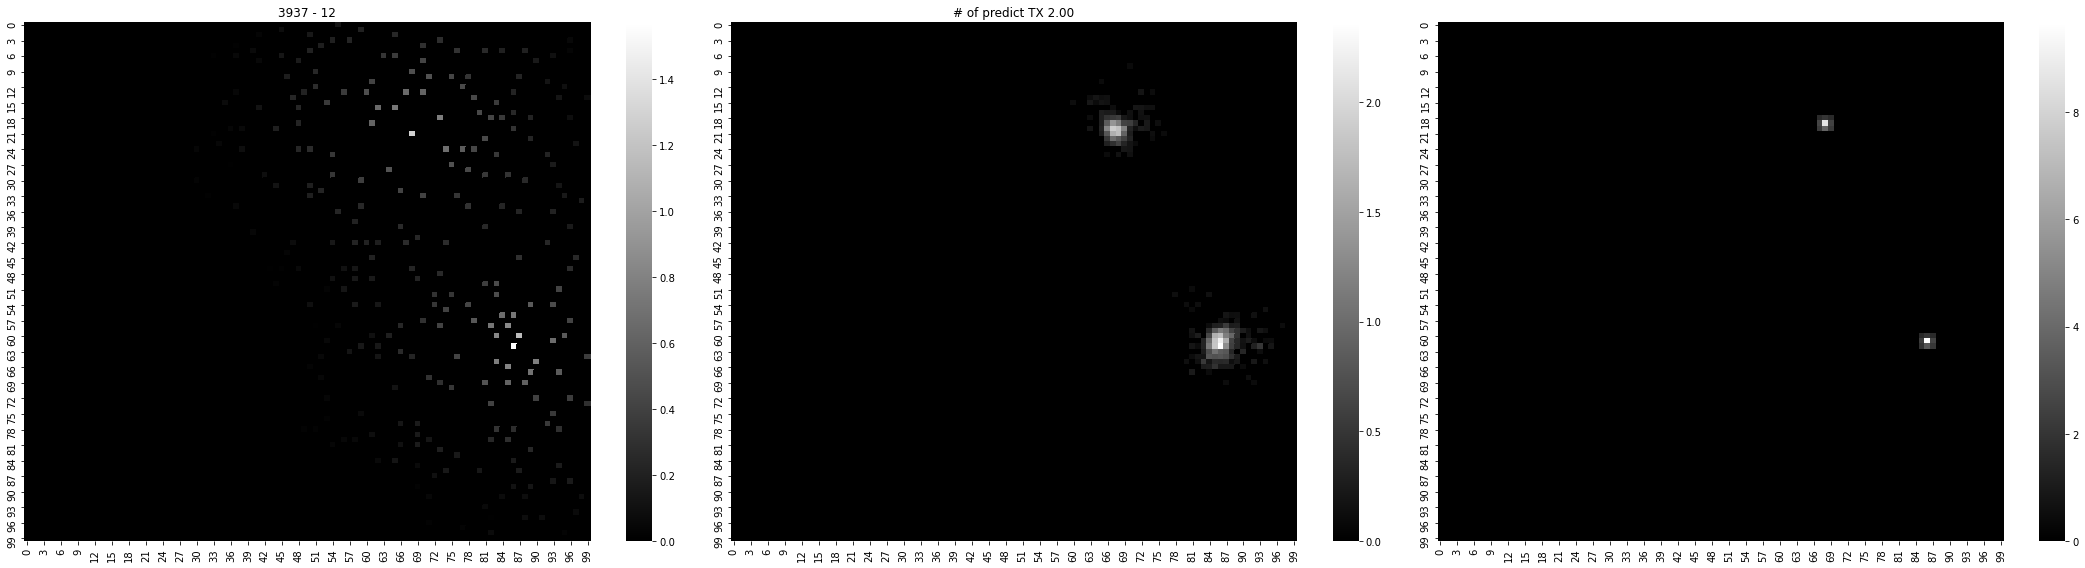

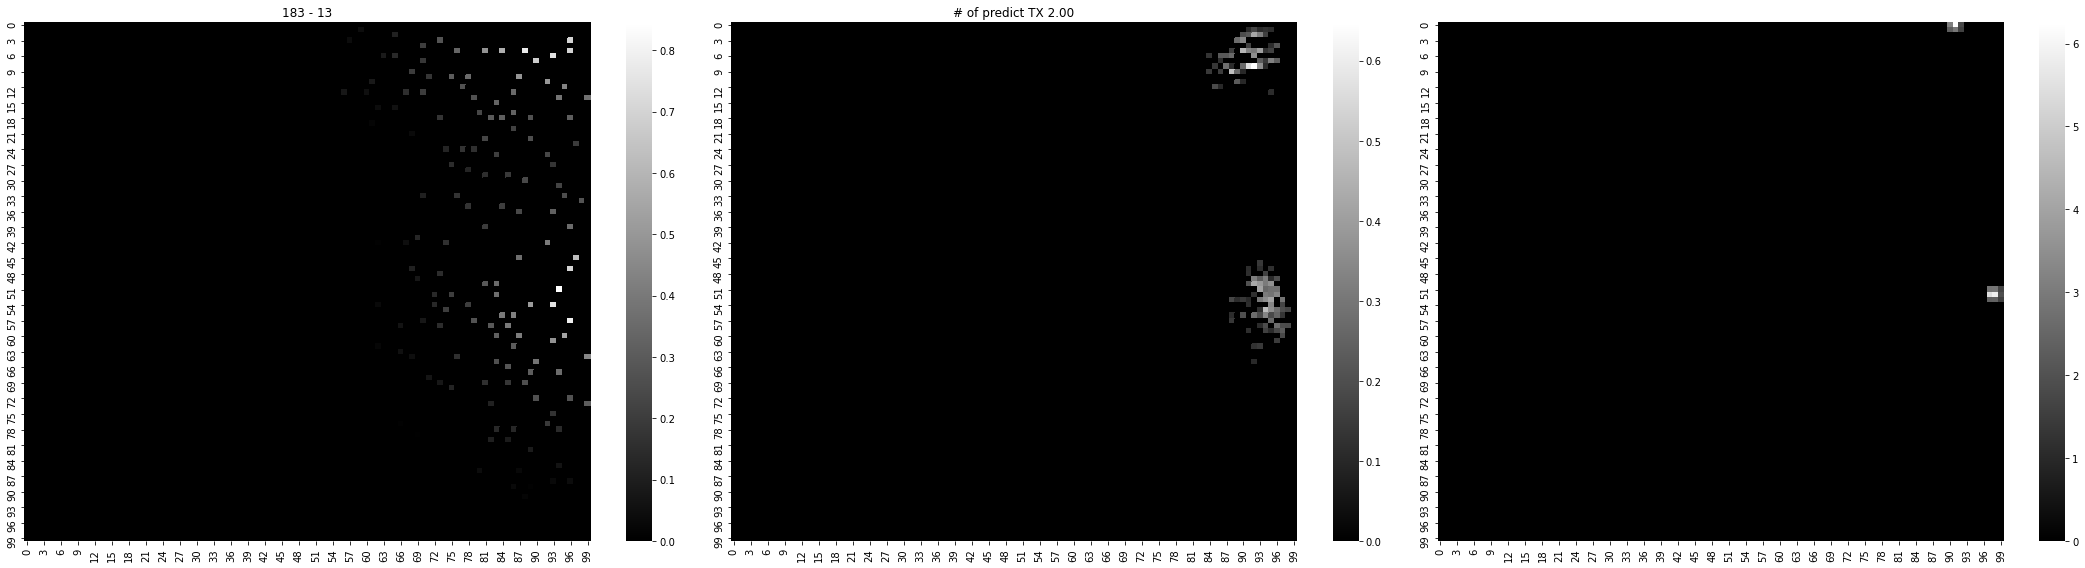

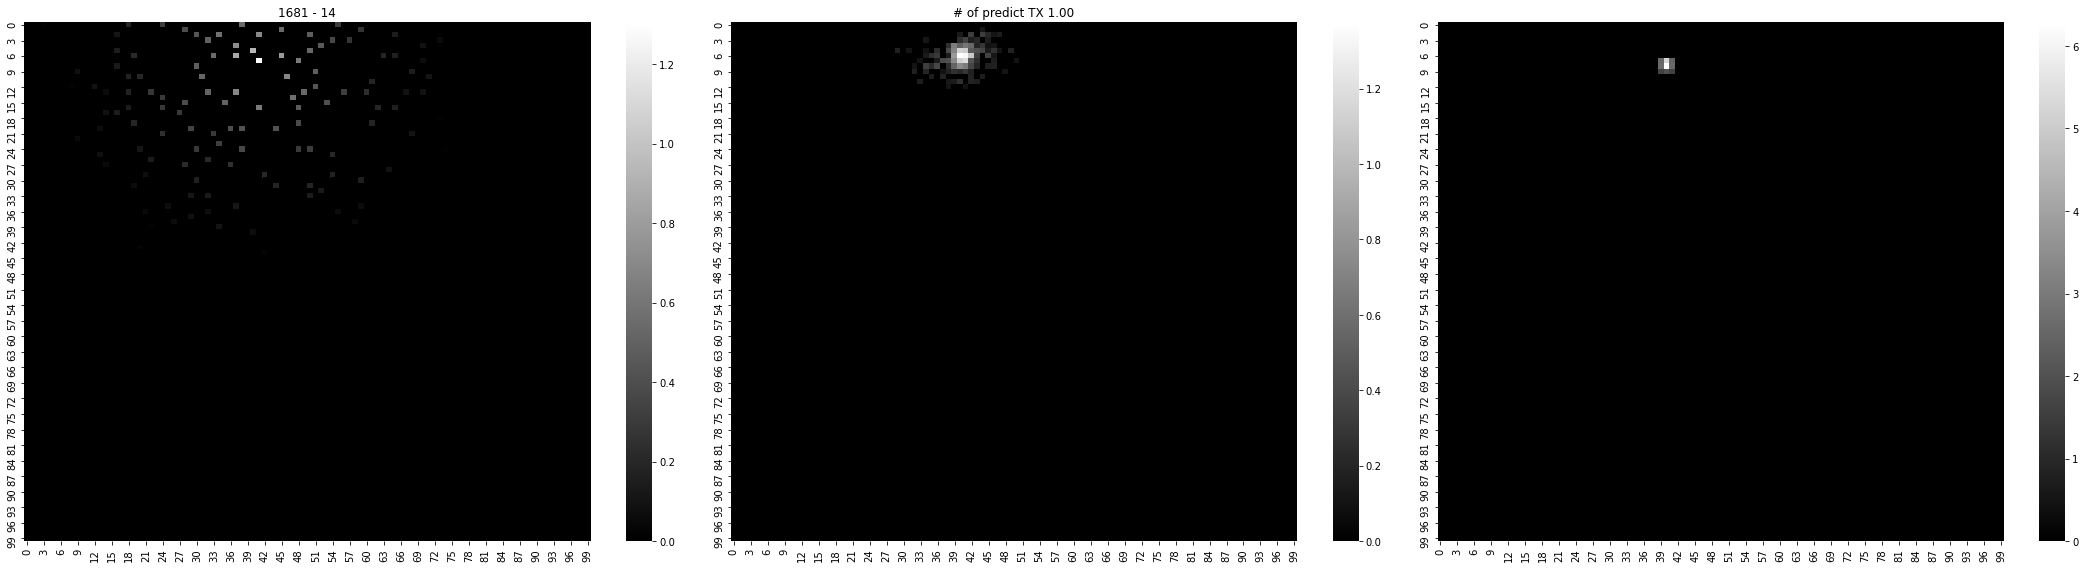

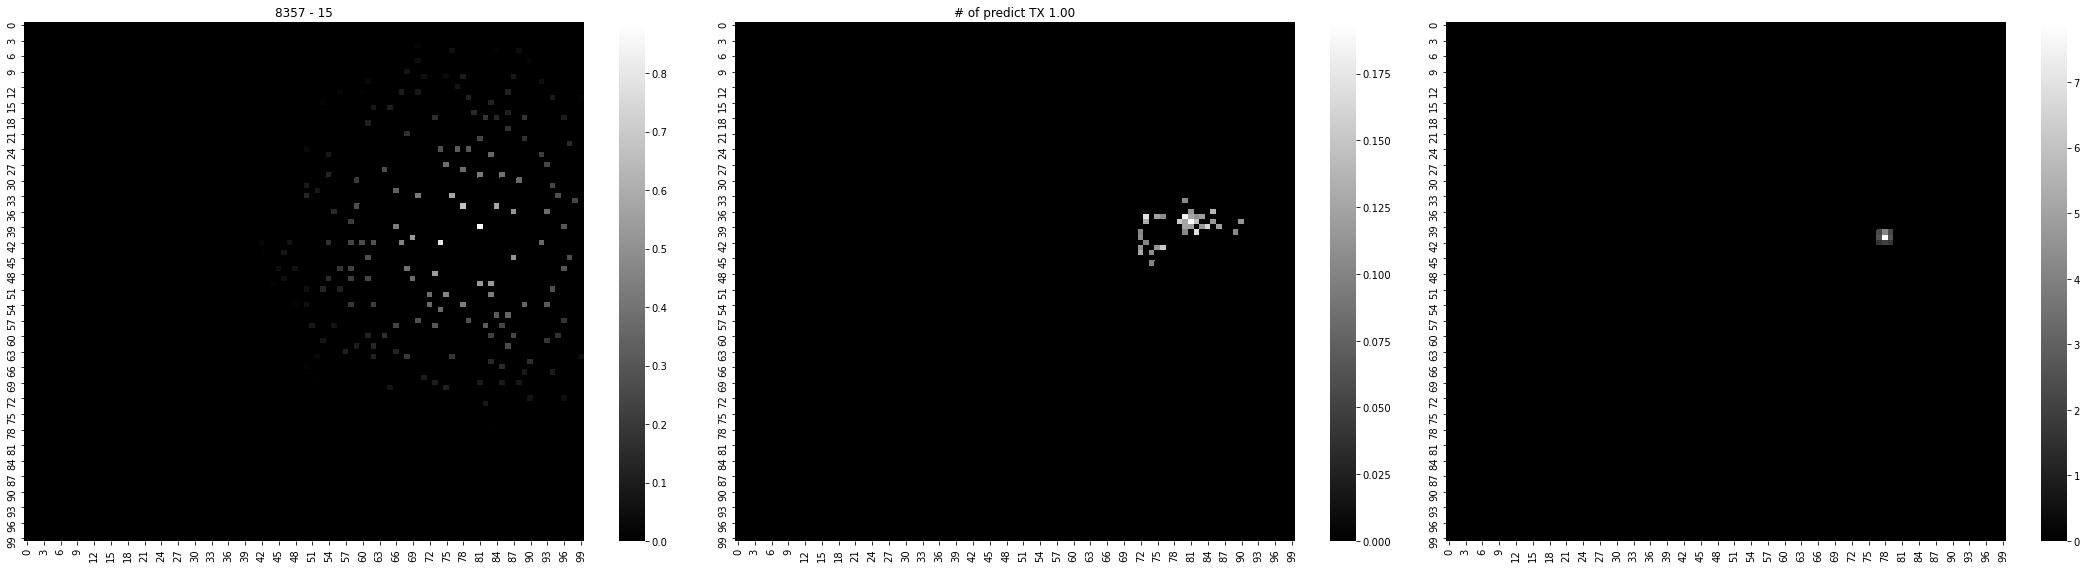

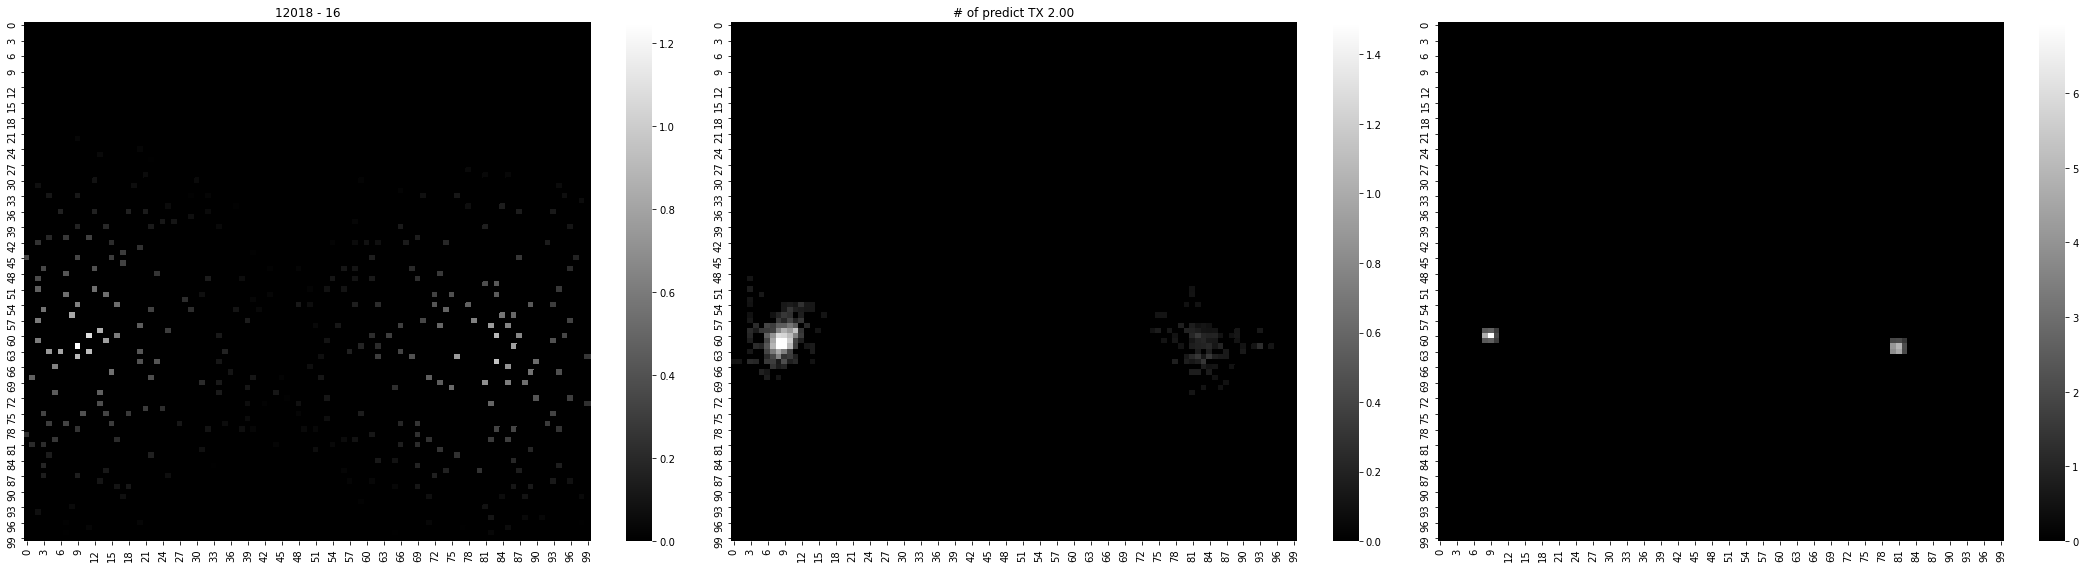

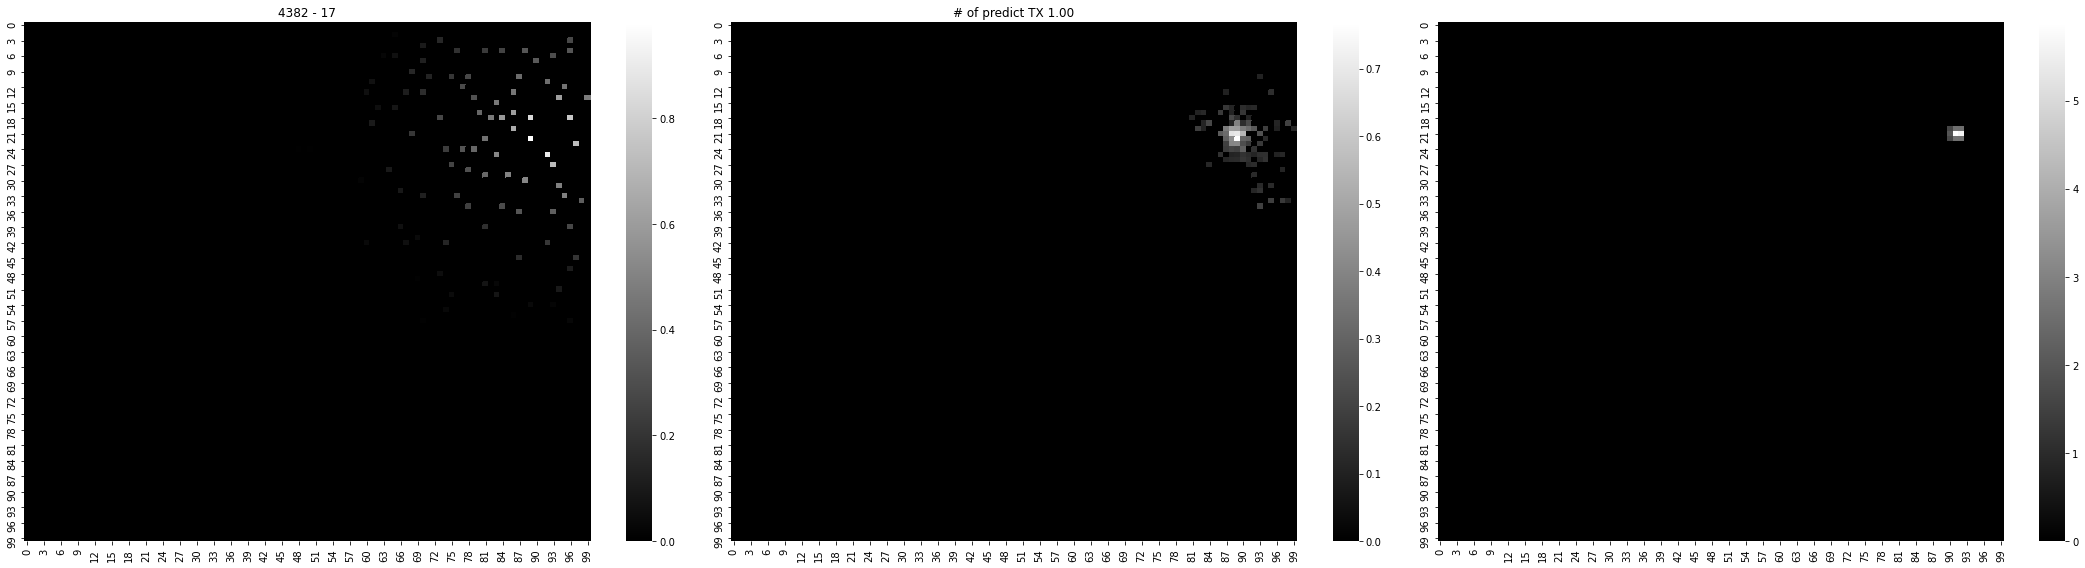

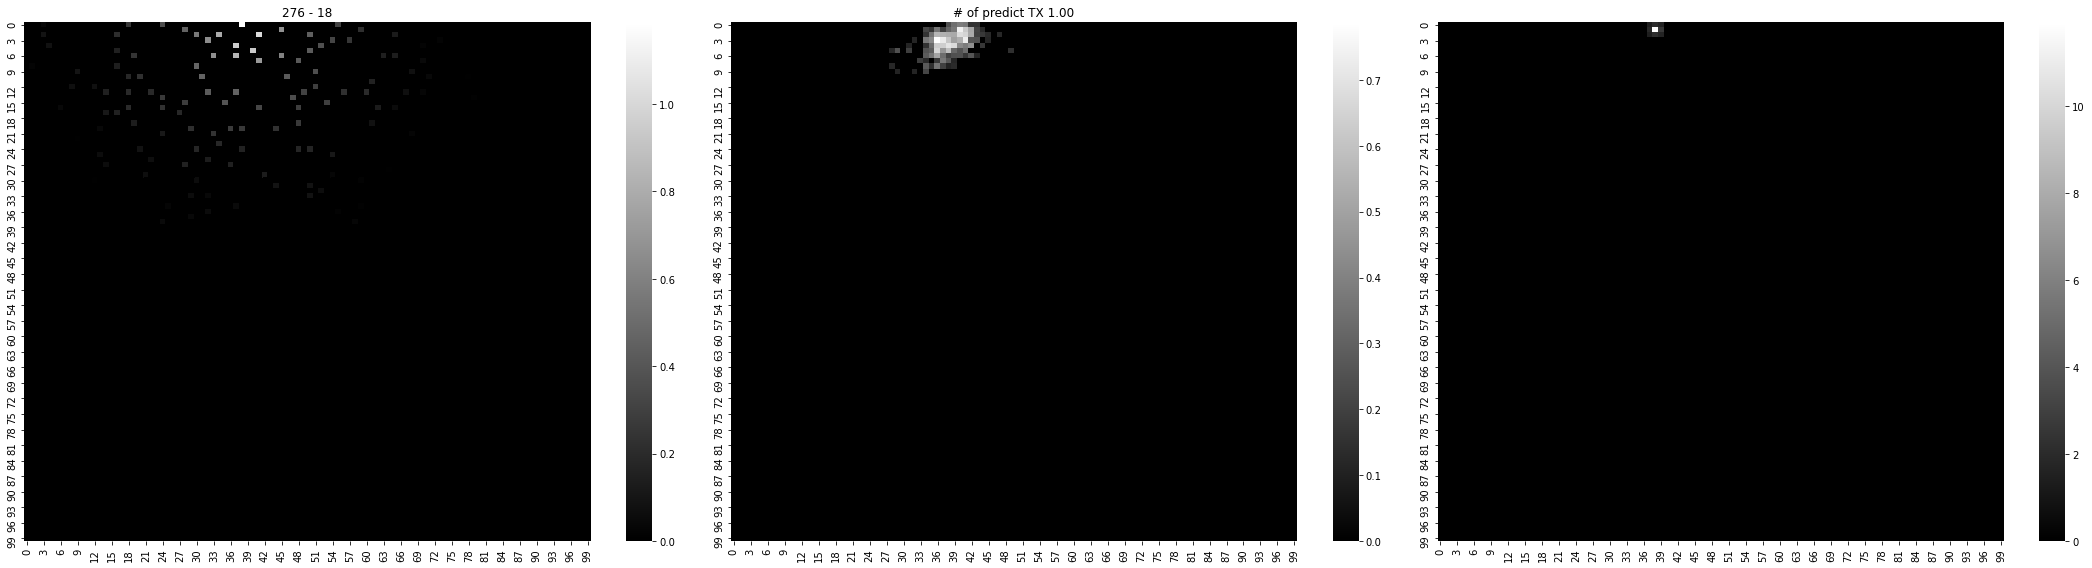

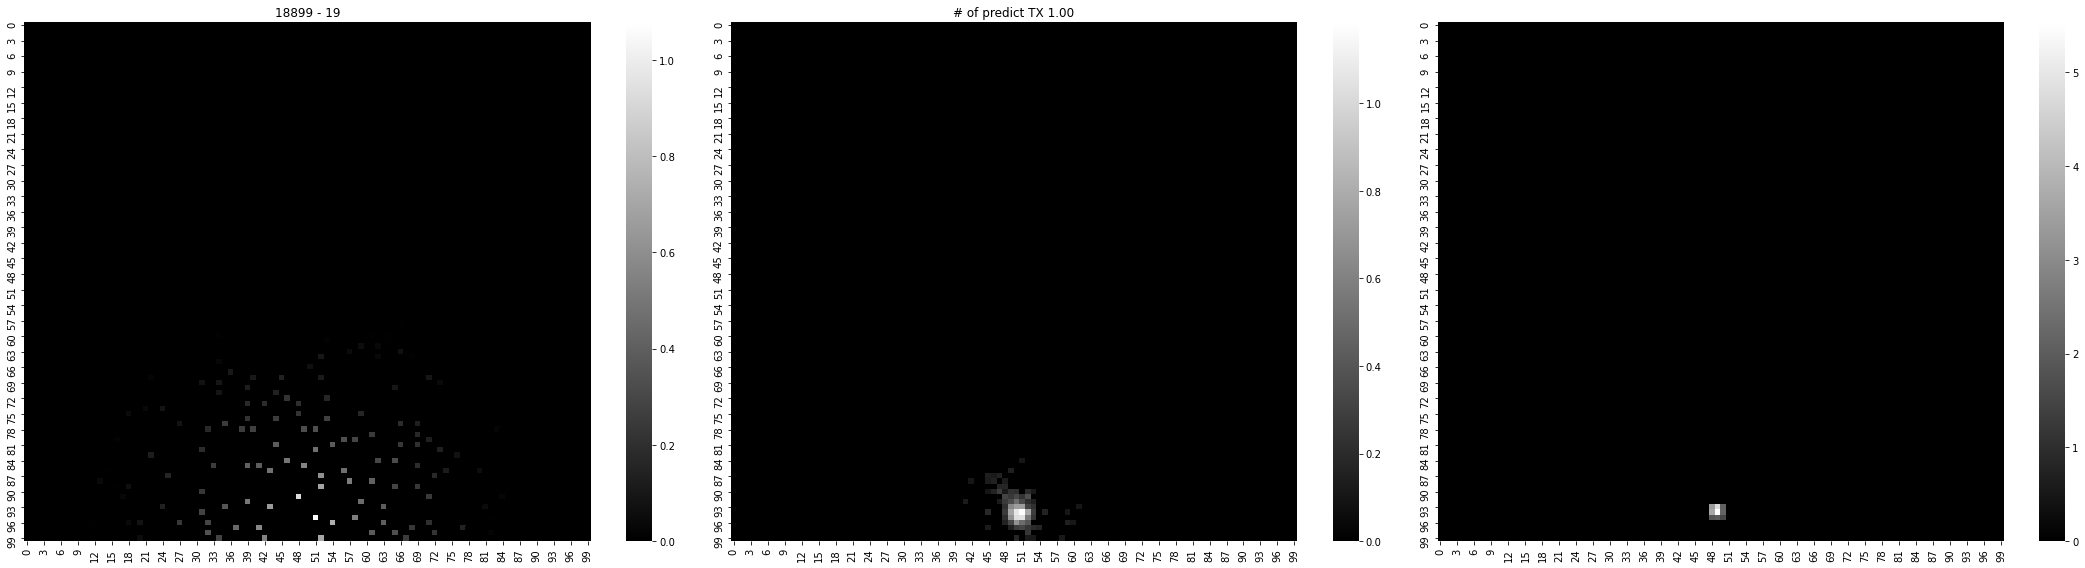

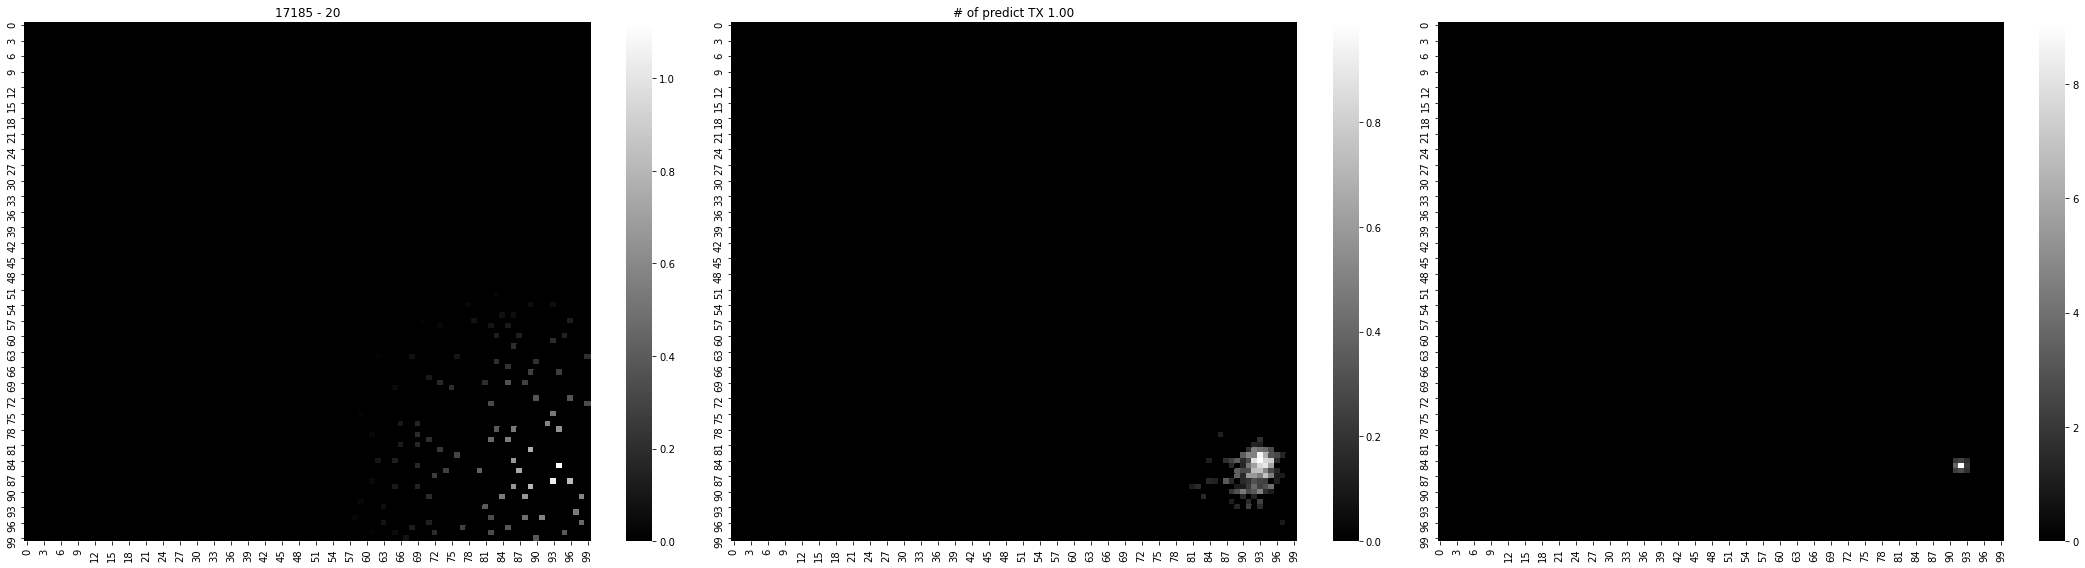

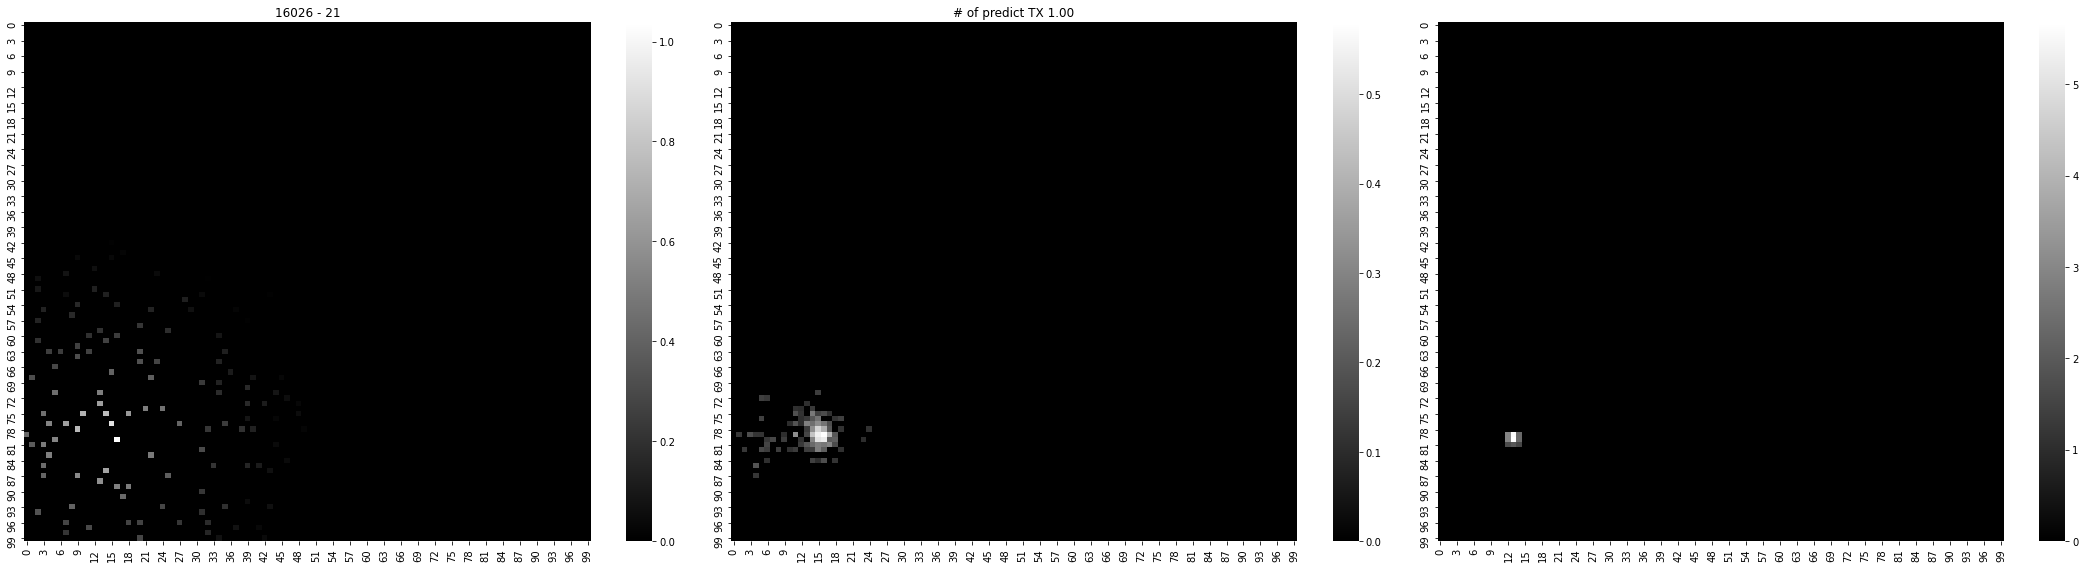

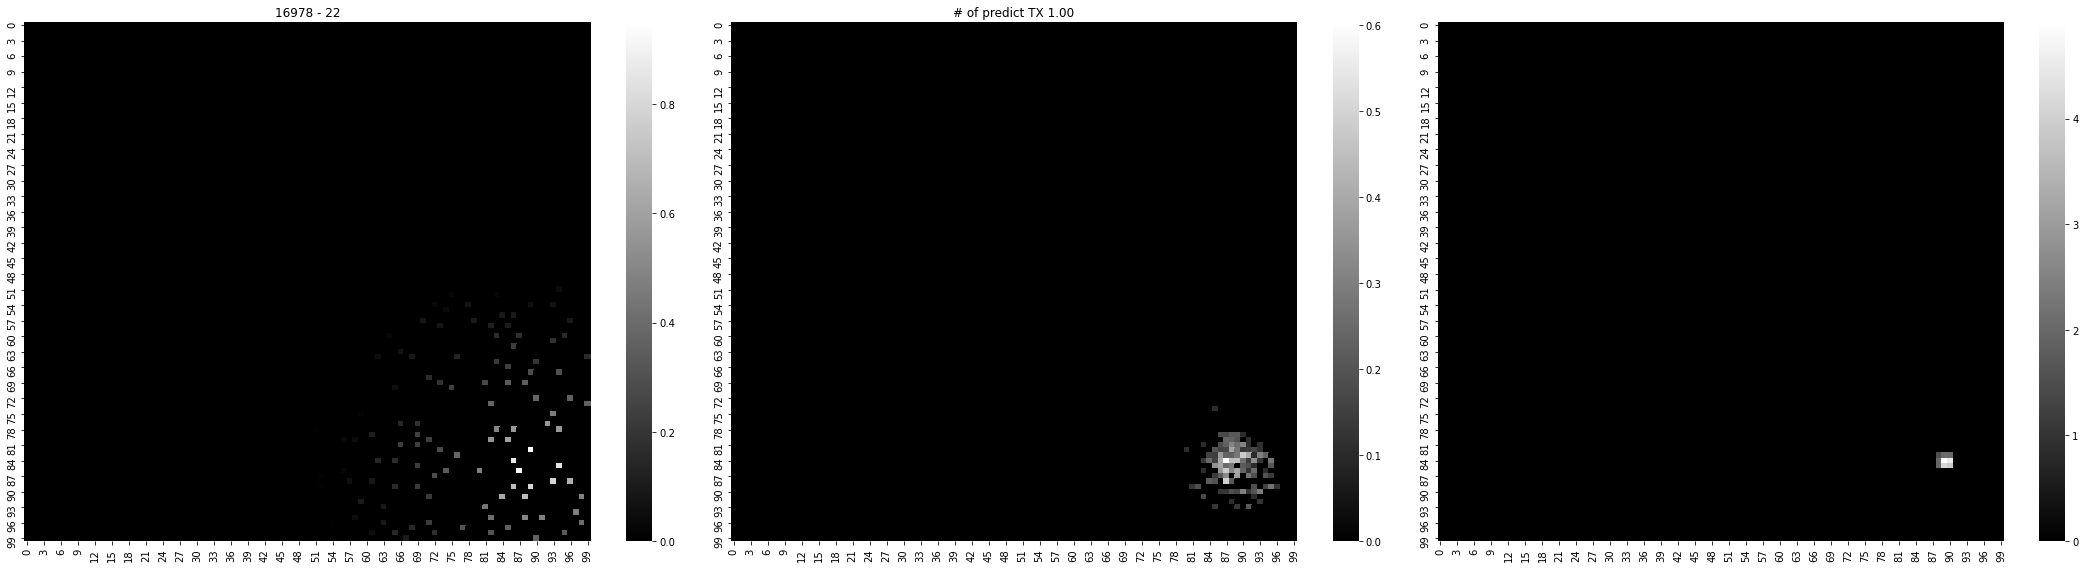

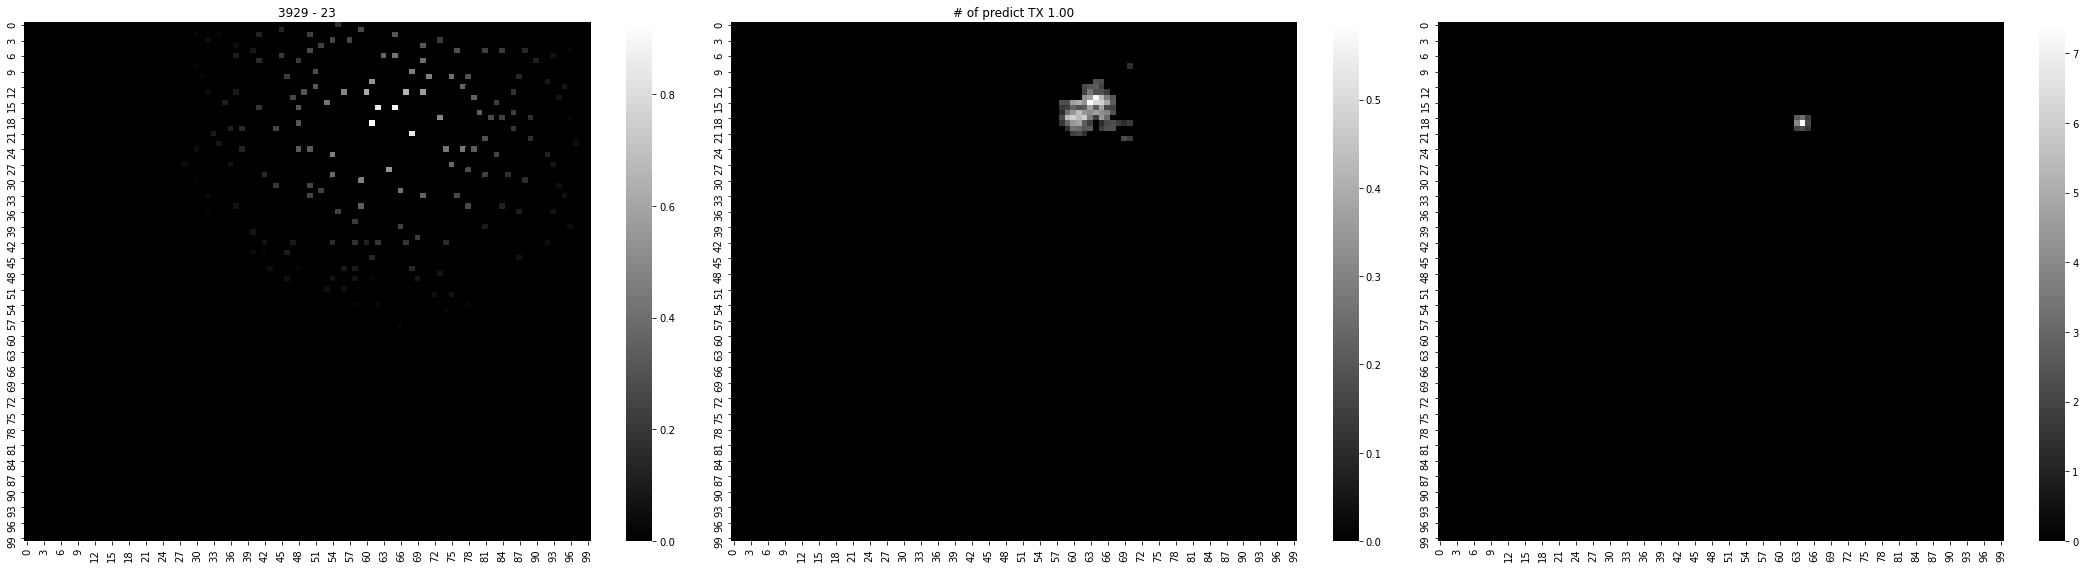

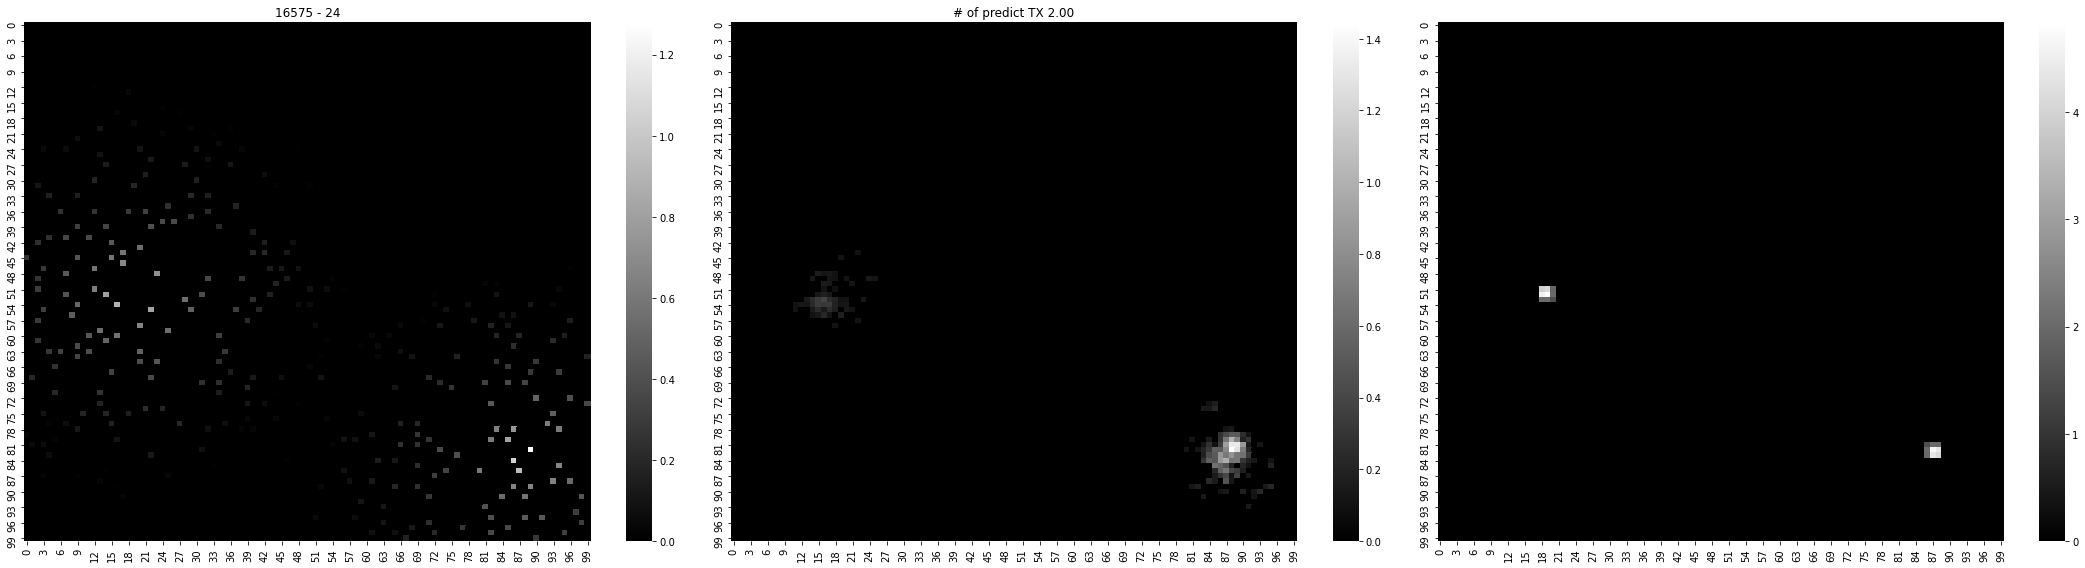

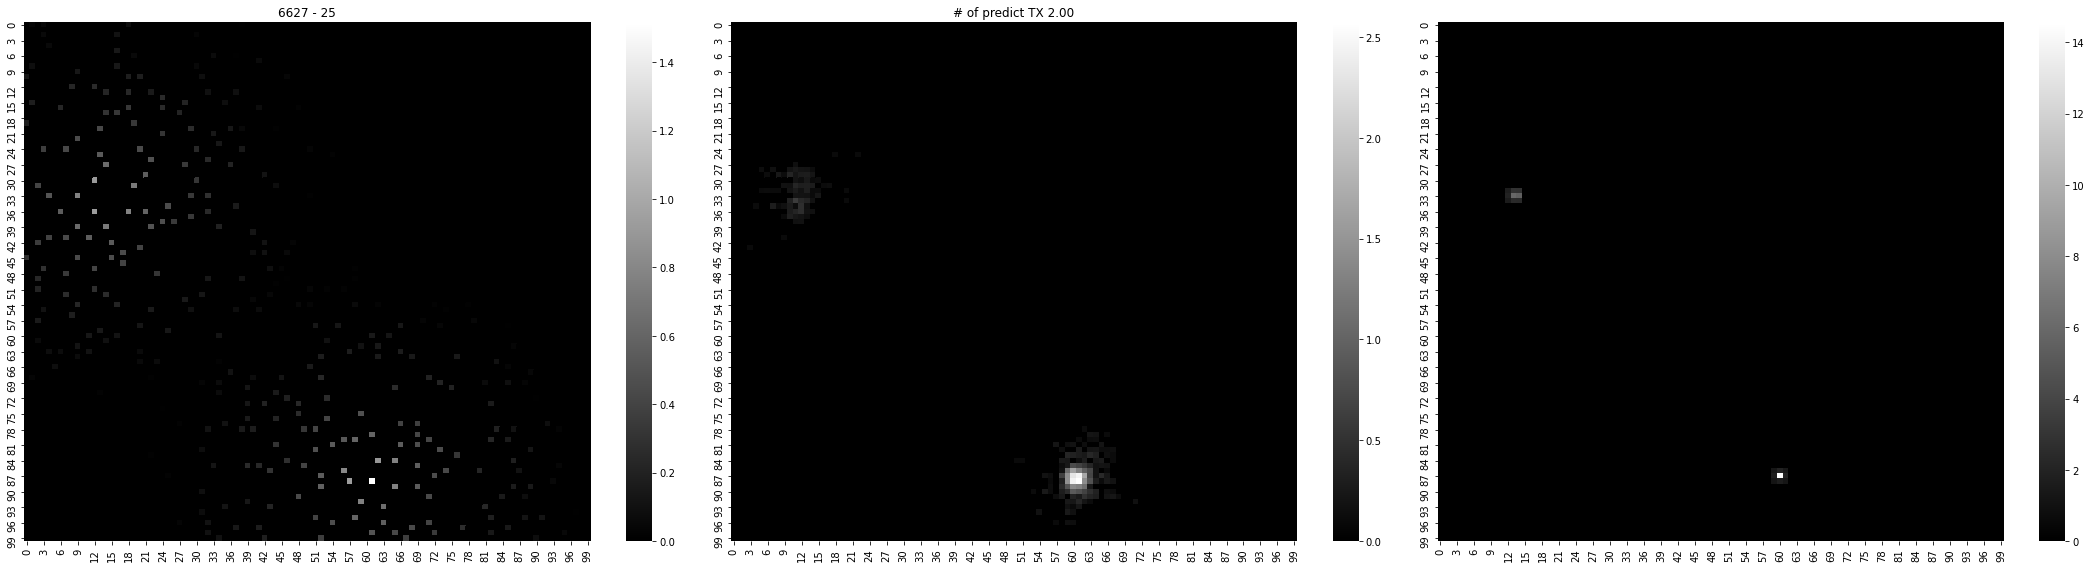

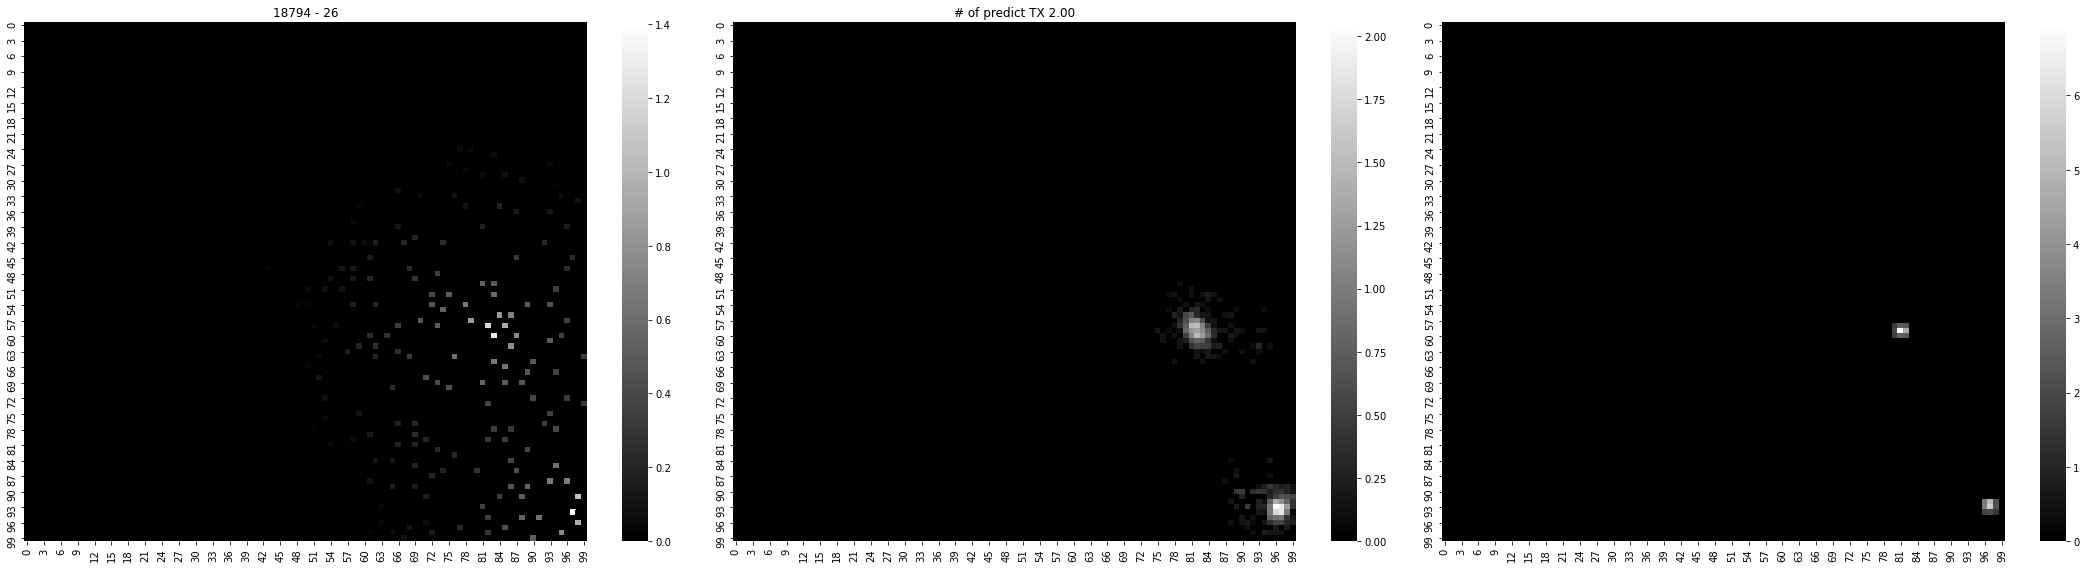

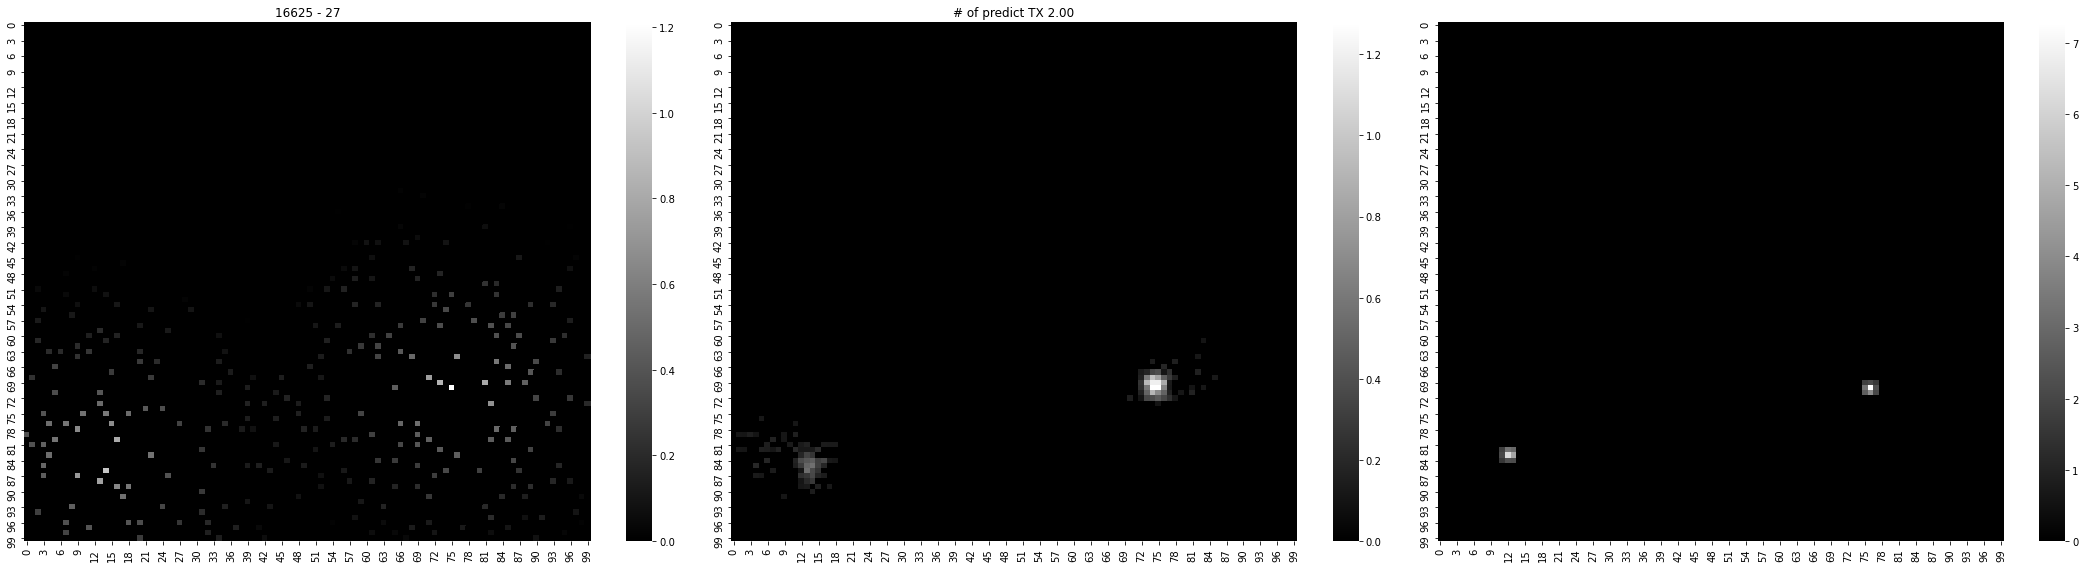

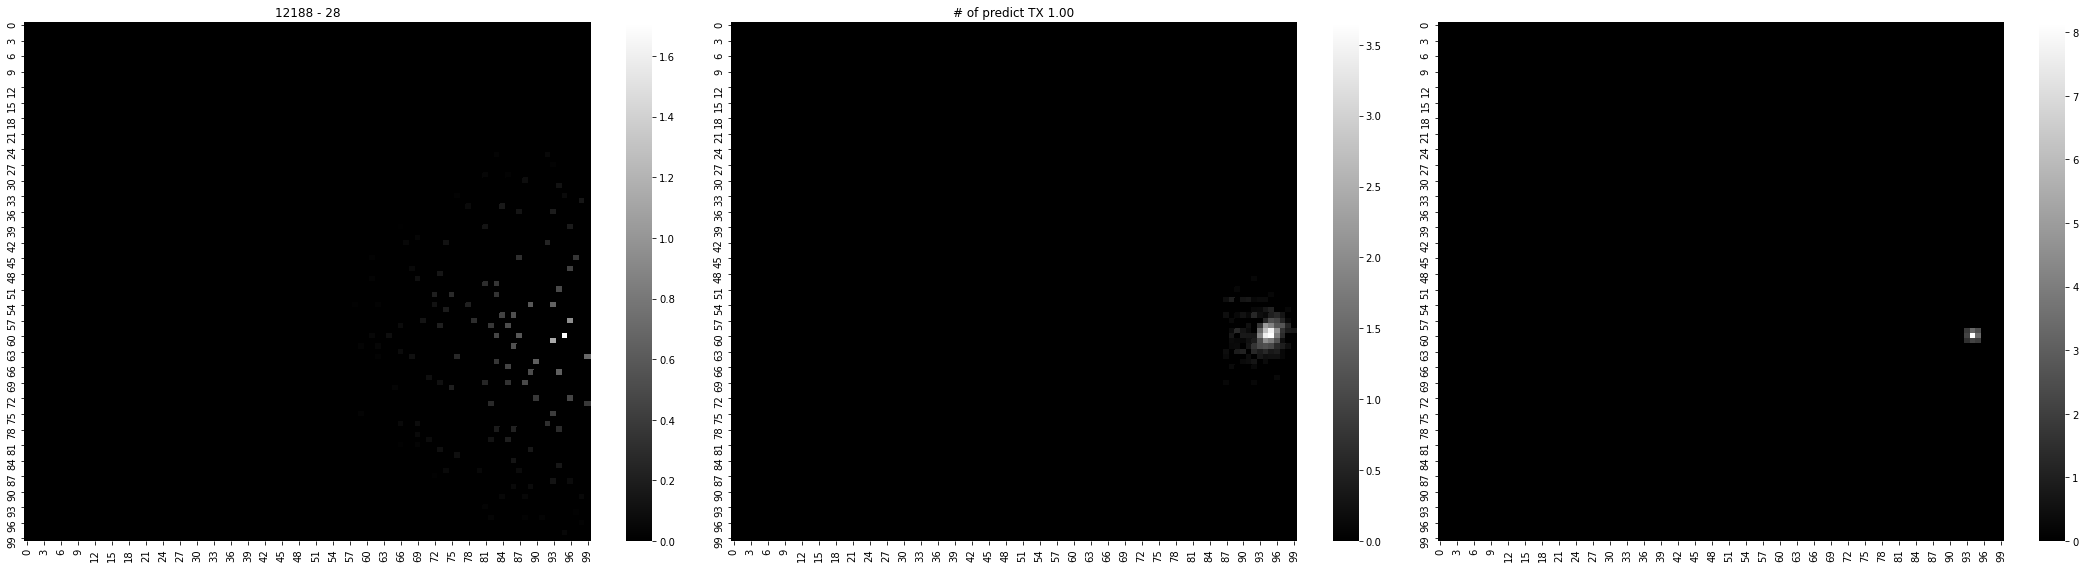

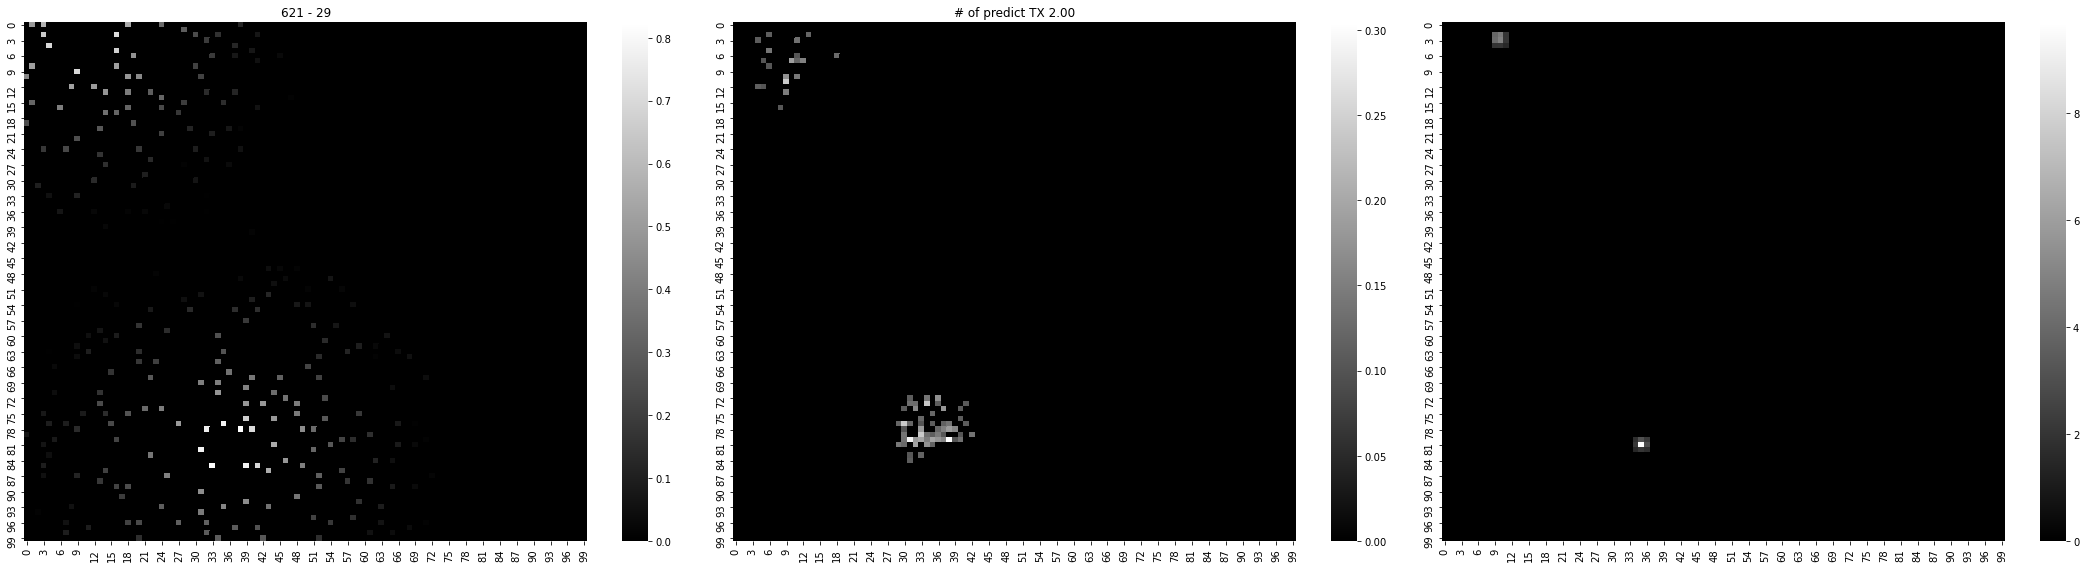

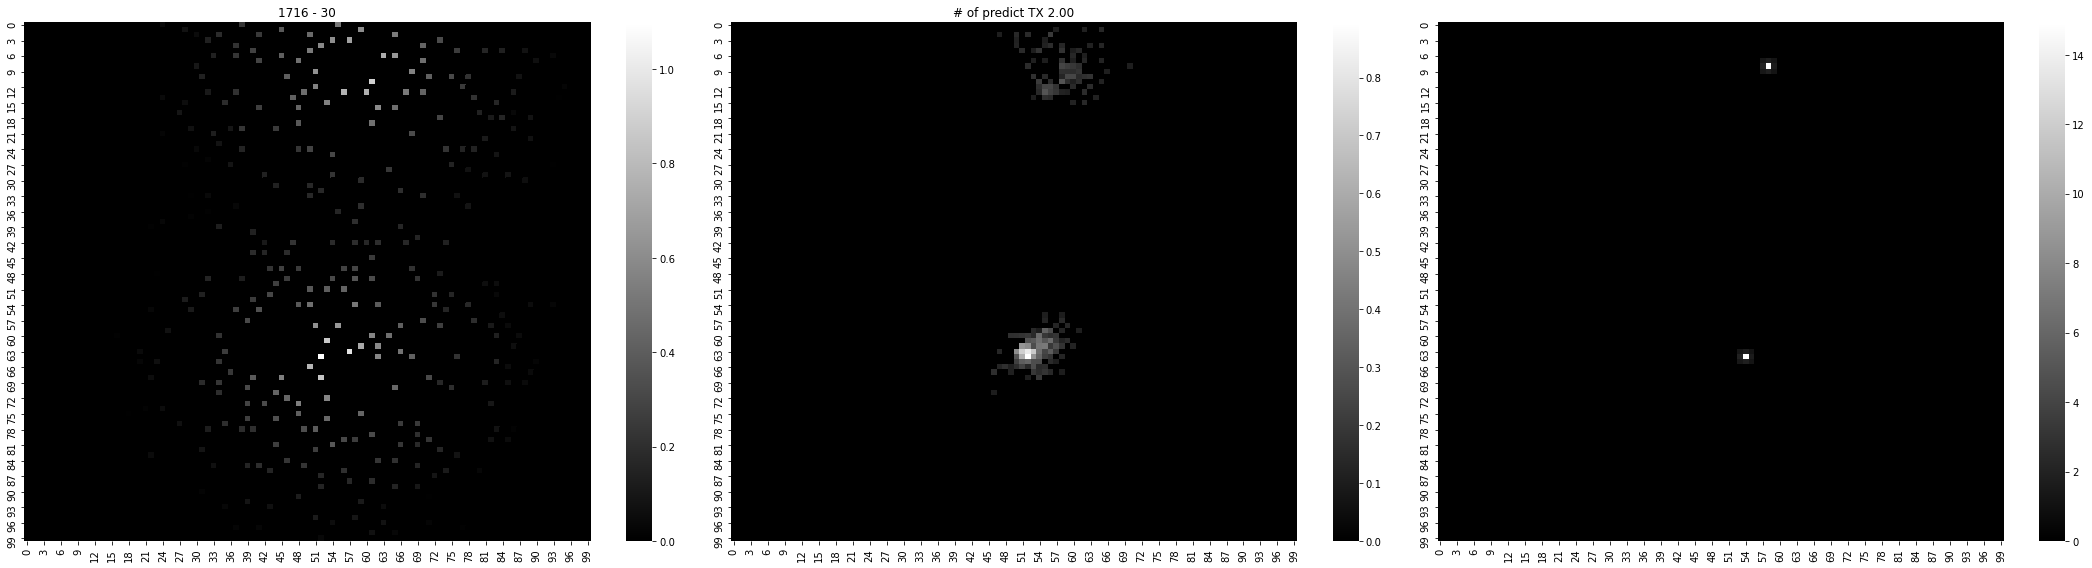

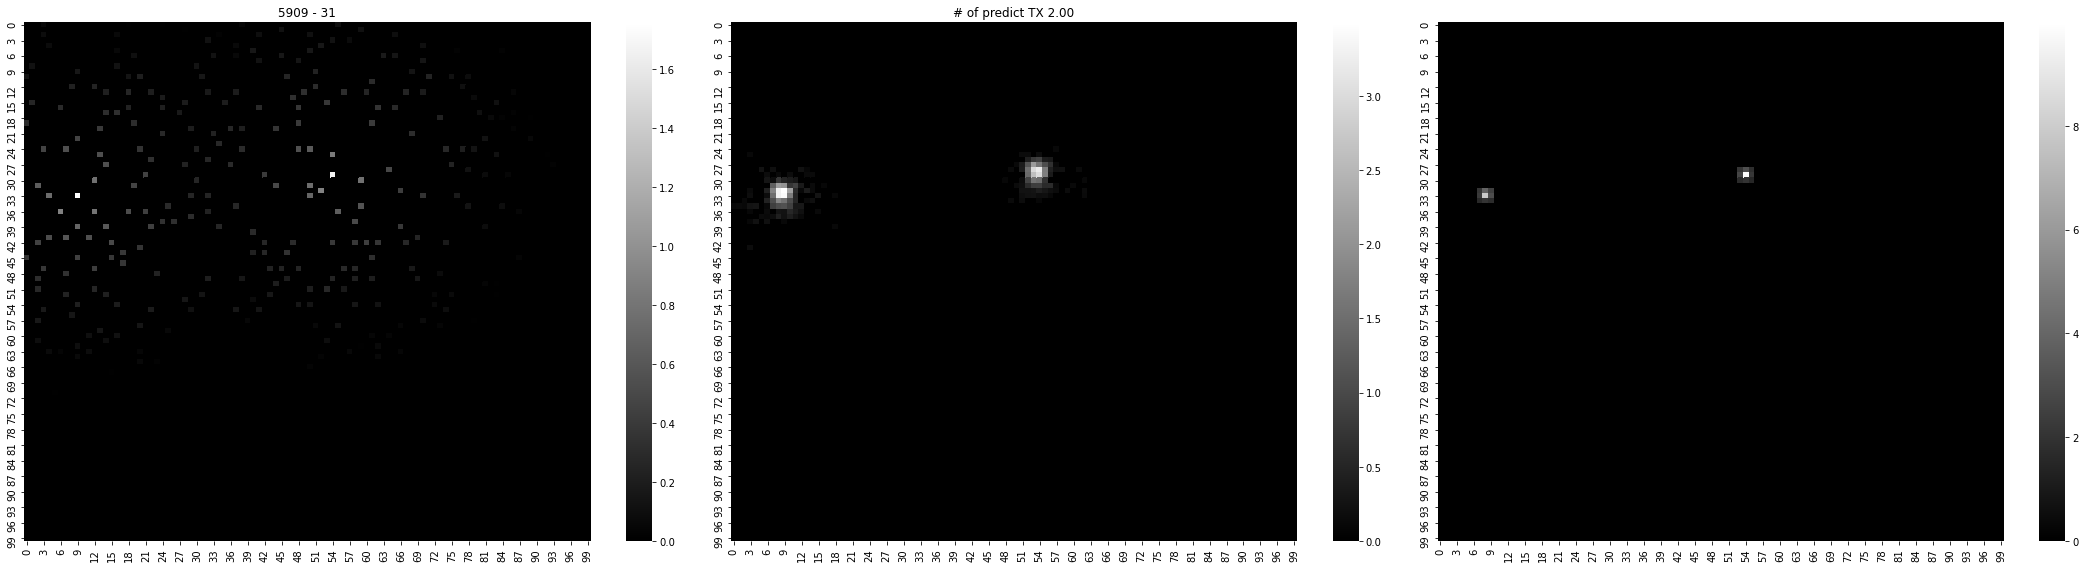

In [12]:
for i in range(len(pred_matrix)):
    myplot(X[i], pred_matrix[i], pred_ntx[i], y[i], indx[i], i)
    print(i, end=' ')

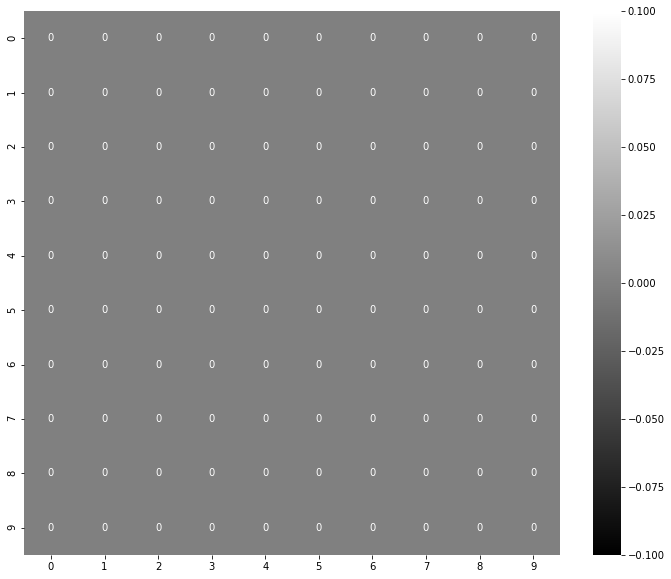

In [20]:
plt.figure(figsize=(12, 10))
ax = sns.heatmap(pred_matrix[i, 0][:10,:10], cmap='gray', annot=True)

# Mics

<class 'numpy.ndarray'> (100, 100) <class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarray'> (100, 100) <class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarray'> (100, 100) <class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarray'> (100, 100) <class 'numpy.ndarray'> (100, 100)


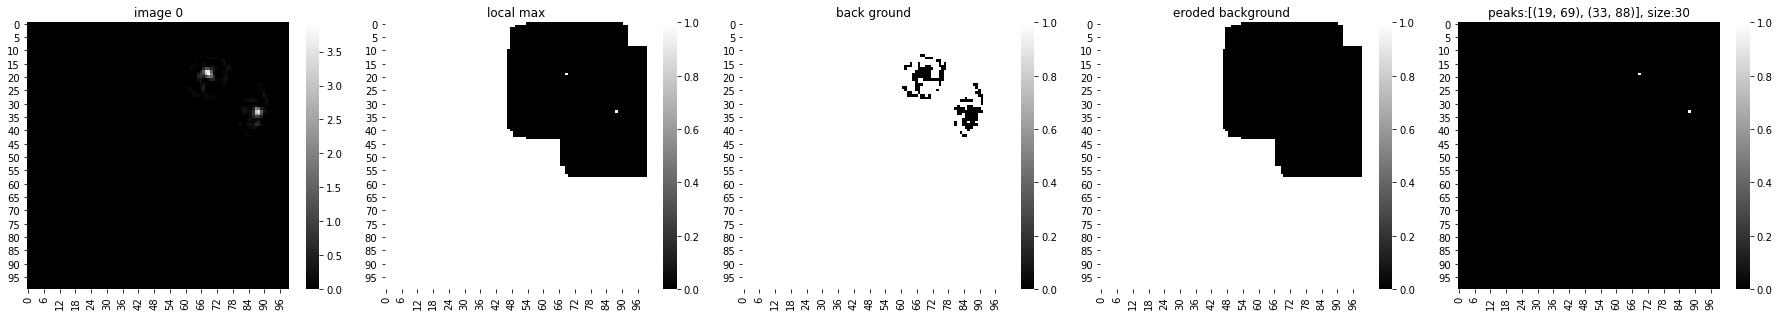

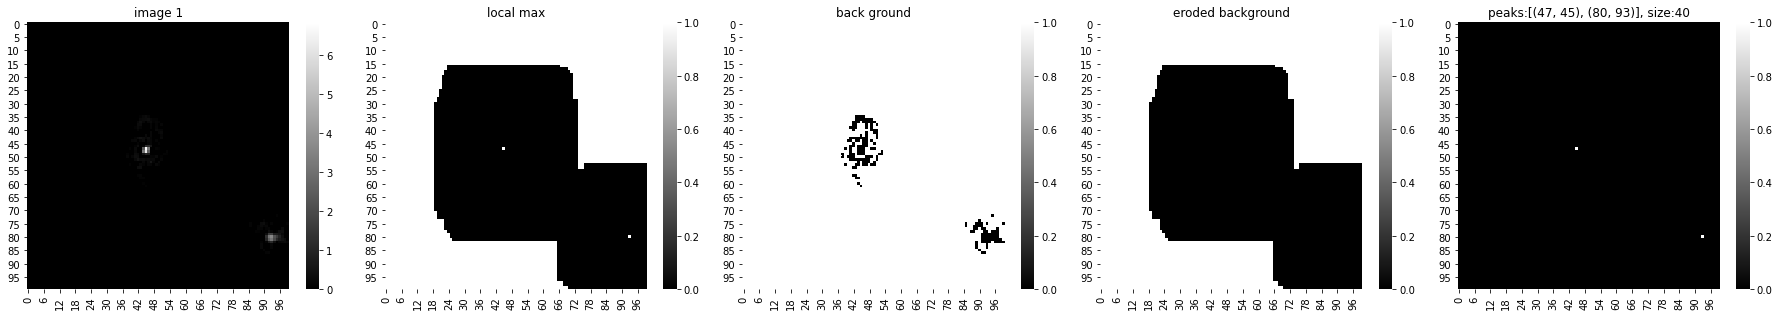

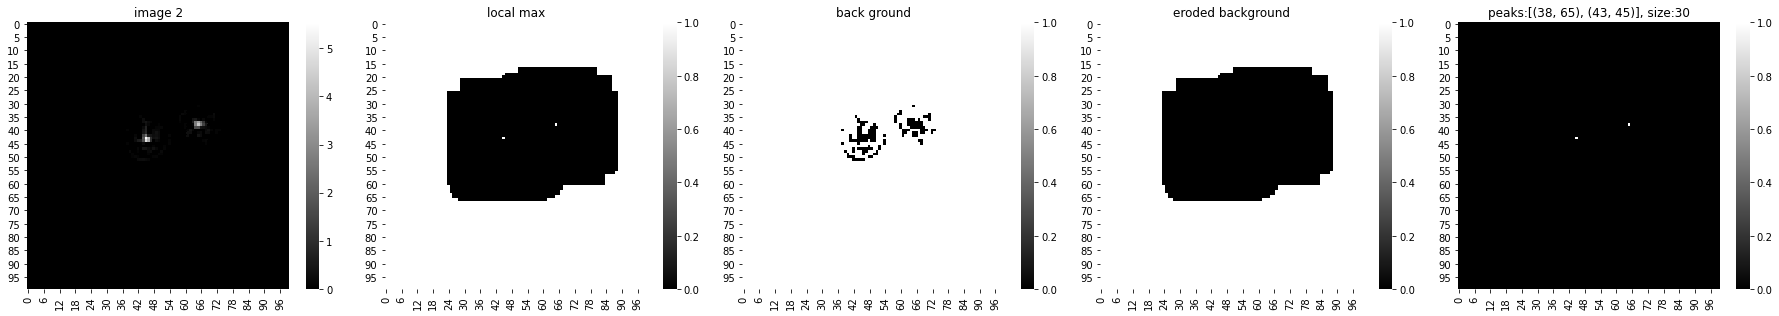

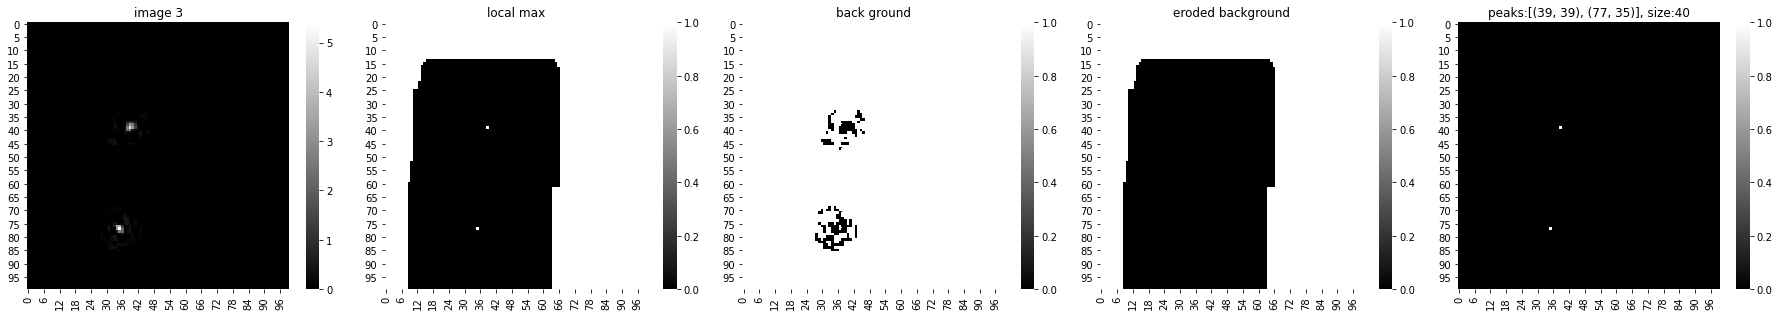

In [25]:
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion

for i in range(4):
    image = pred_matrix[i][0]
    threshold = 0.05
    peaks, size = Utility.detect_peak(image, 2)

    threshold_mask = image < threshold
    image[threshold_mask] = 0

    neighborhood = np.array([[True for _ in range(size)] for _ in range((size))])

    #apply the local maximum filter; all pixel of maximal value 
    #in their neighborhood are set to 1
    local_max = maximum_filter(image, footprint=neighborhood)==image
    #local_max is a mask that contains the peaks we are 
    #looking for, but also the background.
    #In order to isolate the peaks we must remove the background from the mask.
    #we create the mask of the background
    background = (image < 0.05)
    #a little technicality: we must erode the background in order to 
    #successfully subtract it form local_max, otherwise a line will 
    #appear along the background border (artifact of the local maximum filter)
    eroded_background = binary_erosion(background, structure=neighborhood, border_value=1)
    #we obtain the final mask, containing only peaks, 
    #by removing the background from the local_max mask (xor operation)
    print(type(local_max), local_max.shape, type(eroded_background), eroded_background.shape)
    detected_peaks = local_max ^ eroded_background

    fig, axes = plt.subplots(1, 5, figsize=(25, 4.5))
    sns.heatmap(image, cmap='gray', annot=False, ax = axes[0])
    sns.heatmap(local_max, cmap='gray', annot=False, ax = axes[1])
    sns.heatmap(background, cmap='gray', annot=False, ax = axes[2])
    sns.heatmap(eroded_background, cmap='gray', annot=False, ax = axes[3])
    sns.heatmap(detected_peaks, cmap='gray', annot=False, ax = axes[4])
    axes[0].set_title('image {}'.format(i))
    axes[1].set_title('local max')
    axes[2].set_title('back ground')
    axes[3].set_title('eroded background')
    axes[4].set_title('peaks:{}, size:{}'.format(str(peaks), size))
    fig.tight_layout()

In [26]:
indx = np.where(detected_peaks == True)

In [29]:
a = tensor([[1,2]])
b = tensor([[1, 2], [3, 4]])

In [31]:
len(a), len(b)

(1, 2)

In [35]:
zeros = torch.zeros(1, 2)

In [40]:
torch.cat((a, zeros), 0)

tensor([[1., 2.],
        [0., 0.]])